# EDA for Football Data from Transfermarkt
- Kaggle Data URL

    - https://www.kaggle.com/datasets/davidcariboo/player-scores

## 데이터 설명
- Transfermarkt 웹사이트에서 스크레이핑한 각종 축구 데이터 (매주 한번 파일 업데이트)
    - 주요 대회 시즌별 60,000개 이상의 경기
    - 모든 대회의 400개 이상의 클럽들
    - 30,000 이상의 선수들
    - 400,000개 이상의 선수 가치 기록
    - 1,200,000개 이상의 선수 출전 기록

- `csv` 파일 설명
    - `apperances` : 선수 출장 기록
    - `club_games` : 클럽별 경기 홈팀, 어웨이팀 정보
    - `clubs` : 리그별 속해 있는 클럽
    - `competitions` : 대회 정보
    - `game_events` : 경기별 이벤트 정보 (카드, 득점, 어시스트 등)
    - `game_lineups` : 경기별 선수의 선발, 교체 명단 등재 여부
    - `games` : 경기에 대한 정보 (시즌, 라운드, 홈팀, 어웨이팀, 순위)
    - `player_valuations` : Transfermarkt 웹사이트에서 매긴 선수의 가치
    - `players` : 선수에 대한 세부 정보

- 데이터베이스 스키마
    <img src="https://raw.githubusercontent.com/dcaribou/transfermarkt-datasets/master/resources/diagram.svg?sanitize=true" width="1700">

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from datetime import datetime
from datetime import timedelta
import missingno as msno

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 경로
path = "C:/Users/aryij/Documents/DataStudy/DAStudy-sat/Tek/football-data-from-transfermarkt/data/df_preprocessed.csv"
df = pd.read_csv(path)

In [3]:
df.head()

player_name  start_season  yellow_cards  red_cards  goals  assists  \
0   Aaron Connolly          2019             0          0      3        2   
1   Aaron Connolly          2020             0          0      2        1   
2   Aaron Connolly          2021             0          0      0        0   
3  Aaron Cresswell          2019             7          0      3        0   
4  Aaron Cresswell          2020             3          0      0        8   

   minutes_played  total_apps competition_code date_of_birth        position  \
0            1261          24   premier-league    2000-01-28  Centre-Forward   
1             791          17   premier-league    2000-01-28  Centre-Forward   
2             155           4   premier-league    2000-01-28  Centre-Forward   
3            2730          31   premier-league    1989-12-15       Left-Back   
4            3172          36   premier-league    1989-12-15       Left-Back   

                        current_club_name  highest_market_value  \
0  Brighton and Hove Albion Football Club             7000000.0   
1  Brighton and Hove Albion Football Club             7000000.0   
2  Brighton and Hove Albion Football Club             7000000.0   
3           West Ham United Football Club            12000000.0   
4           West Ham United Football Club            12000000.0   

   market_value_per_season  country   foot  height_in_cm  
0                4000000.0  Ireland  right         174.0  
1                7000000.0  Ireland  right         174.0  
2                6000000.0  Ireland  right         174.0  
3                6500000.0  England   left         170.0  
4                5000000.0  England   left         170.0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16001 entries, 0 to 16000
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   player_name              16001 non-null  object 
 1   start_season             16001 non-null  int64  
 2   yellow_cards             16001 non-null  int64  
 3   red_cards                16001 non-null  int64  
 4   goals                    16001 non-null  int64  
 5   assists                  16001 non-null  int64  
 6   minutes_played           16001 non-null  int64  
 7   total_apps               16001 non-null  int64  
 8   competition_code         16001 non-null  object 
 9   date_of_birth            16001 non-null  object 
 10  position                 16001 non-null  object 
 11  current_club_name        16001 non-null  object 
 12  highest_market_value     16001 non-null  float64
 13  market_value_per_season  16001 non-null  float64
 14  country               

In [5]:
# date_of_birth 컬럼 타입 datetime으로 변경
df["date_of_birth"] = pd.to_datetime(df["date_of_birth"], format='%Y-%m-%d')

In [6]:
# 시즌별 만 나이 구하는 함수 생성
def calculate_age(born_col, season_col):
    today = datetime.today()
    # 생일이 지나지 않았다면 현재 연도 - 태어난 연도 - 1년 더 빼준다
    age = today.year - born_col.year - ((today.month, today.day) < (born_col.month, born_col.day))
    # return age, season_col

    # 23-24 시즌
    if season_col == (today.year-1):
        return age
    # 22-23 시즌
    elif season_col == (today.year-2):
        return age-1
    # 21-22 시즌
    elif season_col == (today.year-3):
        return age-2
    # 20-21 시즌
    elif season_col == (today.year-4):
        return age-3
    # 19-20 시즌
    else :
        return age-4
    

In [13]:
# 시즌별 만 나이 구하는 함수 적용
df["age"] = df.apply(lambda row : calculate_age(row["date_of_birth"], row["start_season"]), axis=1)

In [14]:
# start_season 컬럼 타입 object로 변경
df["start_season"] = df["start_season"].astype(str)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16001 entries, 0 to 16000
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   player_name              16001 non-null  object        
 1   start_season             16001 non-null  object        
 2   yellow_cards             16001 non-null  int64         
 3   red_cards                16001 non-null  int64         
 4   goals                    16001 non-null  int64         
 5   assists                  16001 non-null  int64         
 6   minutes_played           16001 non-null  int64         
 7   total_apps               16001 non-null  int64         
 8   competition_code         16001 non-null  object        
 9   date_of_birth            16001 non-null  datetime64[ns]
 10  position                 16001 non-null  object        
 11  current_club_name        16001 non-null  object        
 12  highest_market_value     16001 n

In [16]:
df = df[['player_name', 'start_season', 'yellow_cards', 'red_cards', 'goals',
         'assists', 'minutes_played', 'total_apps', 'competition_code',
         'date_of_birth', 'age', 'position', 'current_club_name', 'highest_market_value', 'market_value_per_season', 'country', 'foot', 'height_in_cm']]

In [17]:
df.head(3)

player_name start_season  yellow_cards  red_cards  goals  assists  \
0  Aaron Connolly         2019             0          0      3        2   
1  Aaron Connolly         2020             0          0      2        1   
2  Aaron Connolly         2021             0          0      0        0   

   minutes_played  total_apps competition_code date_of_birth  age  \
0            1261          24   premier-league    2000-01-28   20   
1             791          17   premier-league    2000-01-28   21   
2             155           4   premier-league    2000-01-28   22   

         position                       current_club_name  \
0  Centre-Forward  Brighton and Hove Albion Football Club   
1  Centre-Forward  Brighton and Hove Albion Football Club   
2  Centre-Forward  Brighton and Hove Albion Football Club   

   highest_market_value  market_value_per_season  country   foot  height_in_cm  
0             7000000.0                4000000.0  Ireland  right         174.0  
1             7000000.0                7000000.0  Ireland  right         174.0  
2             7000000.0                6000000.0  Ireland  right         174.0

### `.describe()` 확인

In [19]:
df.describe()

yellow_cards     red_cards         goals       assists  minutes_played  \
count  16001.000000  16001.000000  16001.000000  16001.000000    16001.000000   
mean       2.655397      0.070371      1.649772      1.281982     1213.143491   
min        0.000000      0.000000      0.000000      0.000000        1.000000   
25%        0.000000      0.000000      0.000000      0.000000      360.000000   
50%        2.000000      0.000000      0.000000      0.000000     1103.000000   
75%        4.000000      0.000000      2.000000      2.000000     1933.000000   
max       18.000000      3.000000     41.000000     22.000000     3420.000000   
std        2.683233      0.271657      3.095151      2.062306      924.900697   

         total_apps                  date_of_birth           age  \
count  16001.000000                          16001  16001.000000   
mean      18.343479  1995-09-16 11:28:59.816261504     25.970877   
min        1.000000            1977-09-13 00:00:00     16.000000   
25%        9.000000            1992-06-18 00:00:00     23.000000   
50%       19.000000            1996-01-24 00:00:00     26.000000   
75%       27.000000            1999-03-01 00:00:00     29.000000   
max       39.000000            2007-10-02 00:00:00     43.000000   
std       10.842913                            NaN      4.425794   

       highest_market_value  market_value_per_season  height_in_cm  
count          1.600100e+04             1.600100e+04  16001.000000  
mean           1.654632e+07             9.289160e+06    182.504093  
min            5.000000e+04             2.500000e+04    162.000000  
25%            3.000000e+06             1.200000e+06    178.000000  
50%            9.000000e+06             3.500000e+06    183.000000  
75%            2.200000e+07             1.100000e+07    187.000000  
max            2.000000e+08             1.800000e+08    206.000000  
std            2.153660e+07             1.468148e+07      6.627018

In [20]:
df.describe(include="object")

player_name start_season competition_code     position  \
count        16001        16001            16001        16001   
unique        6062            5                6           13   
top     João Pedro         2020          serie-a  Centre-Back   
freq            19         3394             3003         2902   

                     current_club_name country   foot  
count                            16001   16001  16001  
unique                             281     126      3  
top     Newcastle United Football Club   Spain  right  
freq                               163    1998  11368

### 분포 확인

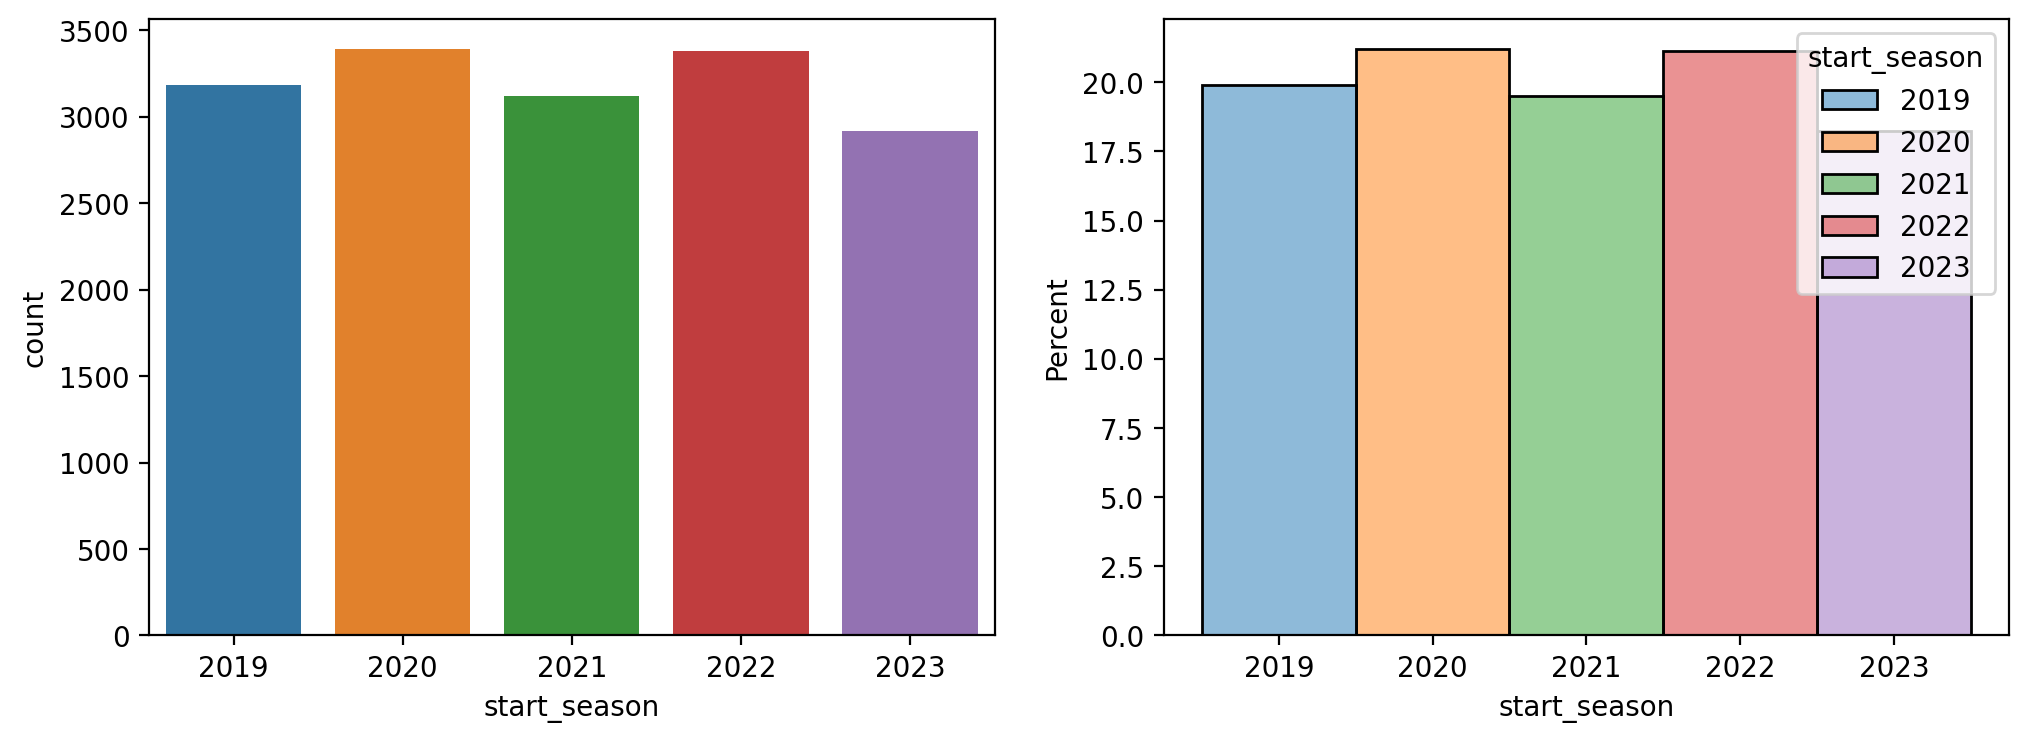

In [21]:
# season별 데이터 숫자 분포 확인
# 숫자 count, 비율도 함께 확인

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

g1 = sns.countplot(data=df, x="start_season", hue="start_season", ax=axes[0])
g2 = sns.histplot(data=df, x="start_season", hue="start_season", stat="percent", ax=axes[1])


## 이상치 확인
- `boxplot` 그려서 확인

In [22]:
# num_cols = df.select_dtypes(include="number").columns.drop("last_season").tolist()
num_cols = df.select_dtypes(include="number").columns.tolist()

print(num_cols)
print(len(num_cols))

['yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played', 'total_apps', 'age', 'highest_market_value', 'market_value_per_season', 'height_in_cm']
10


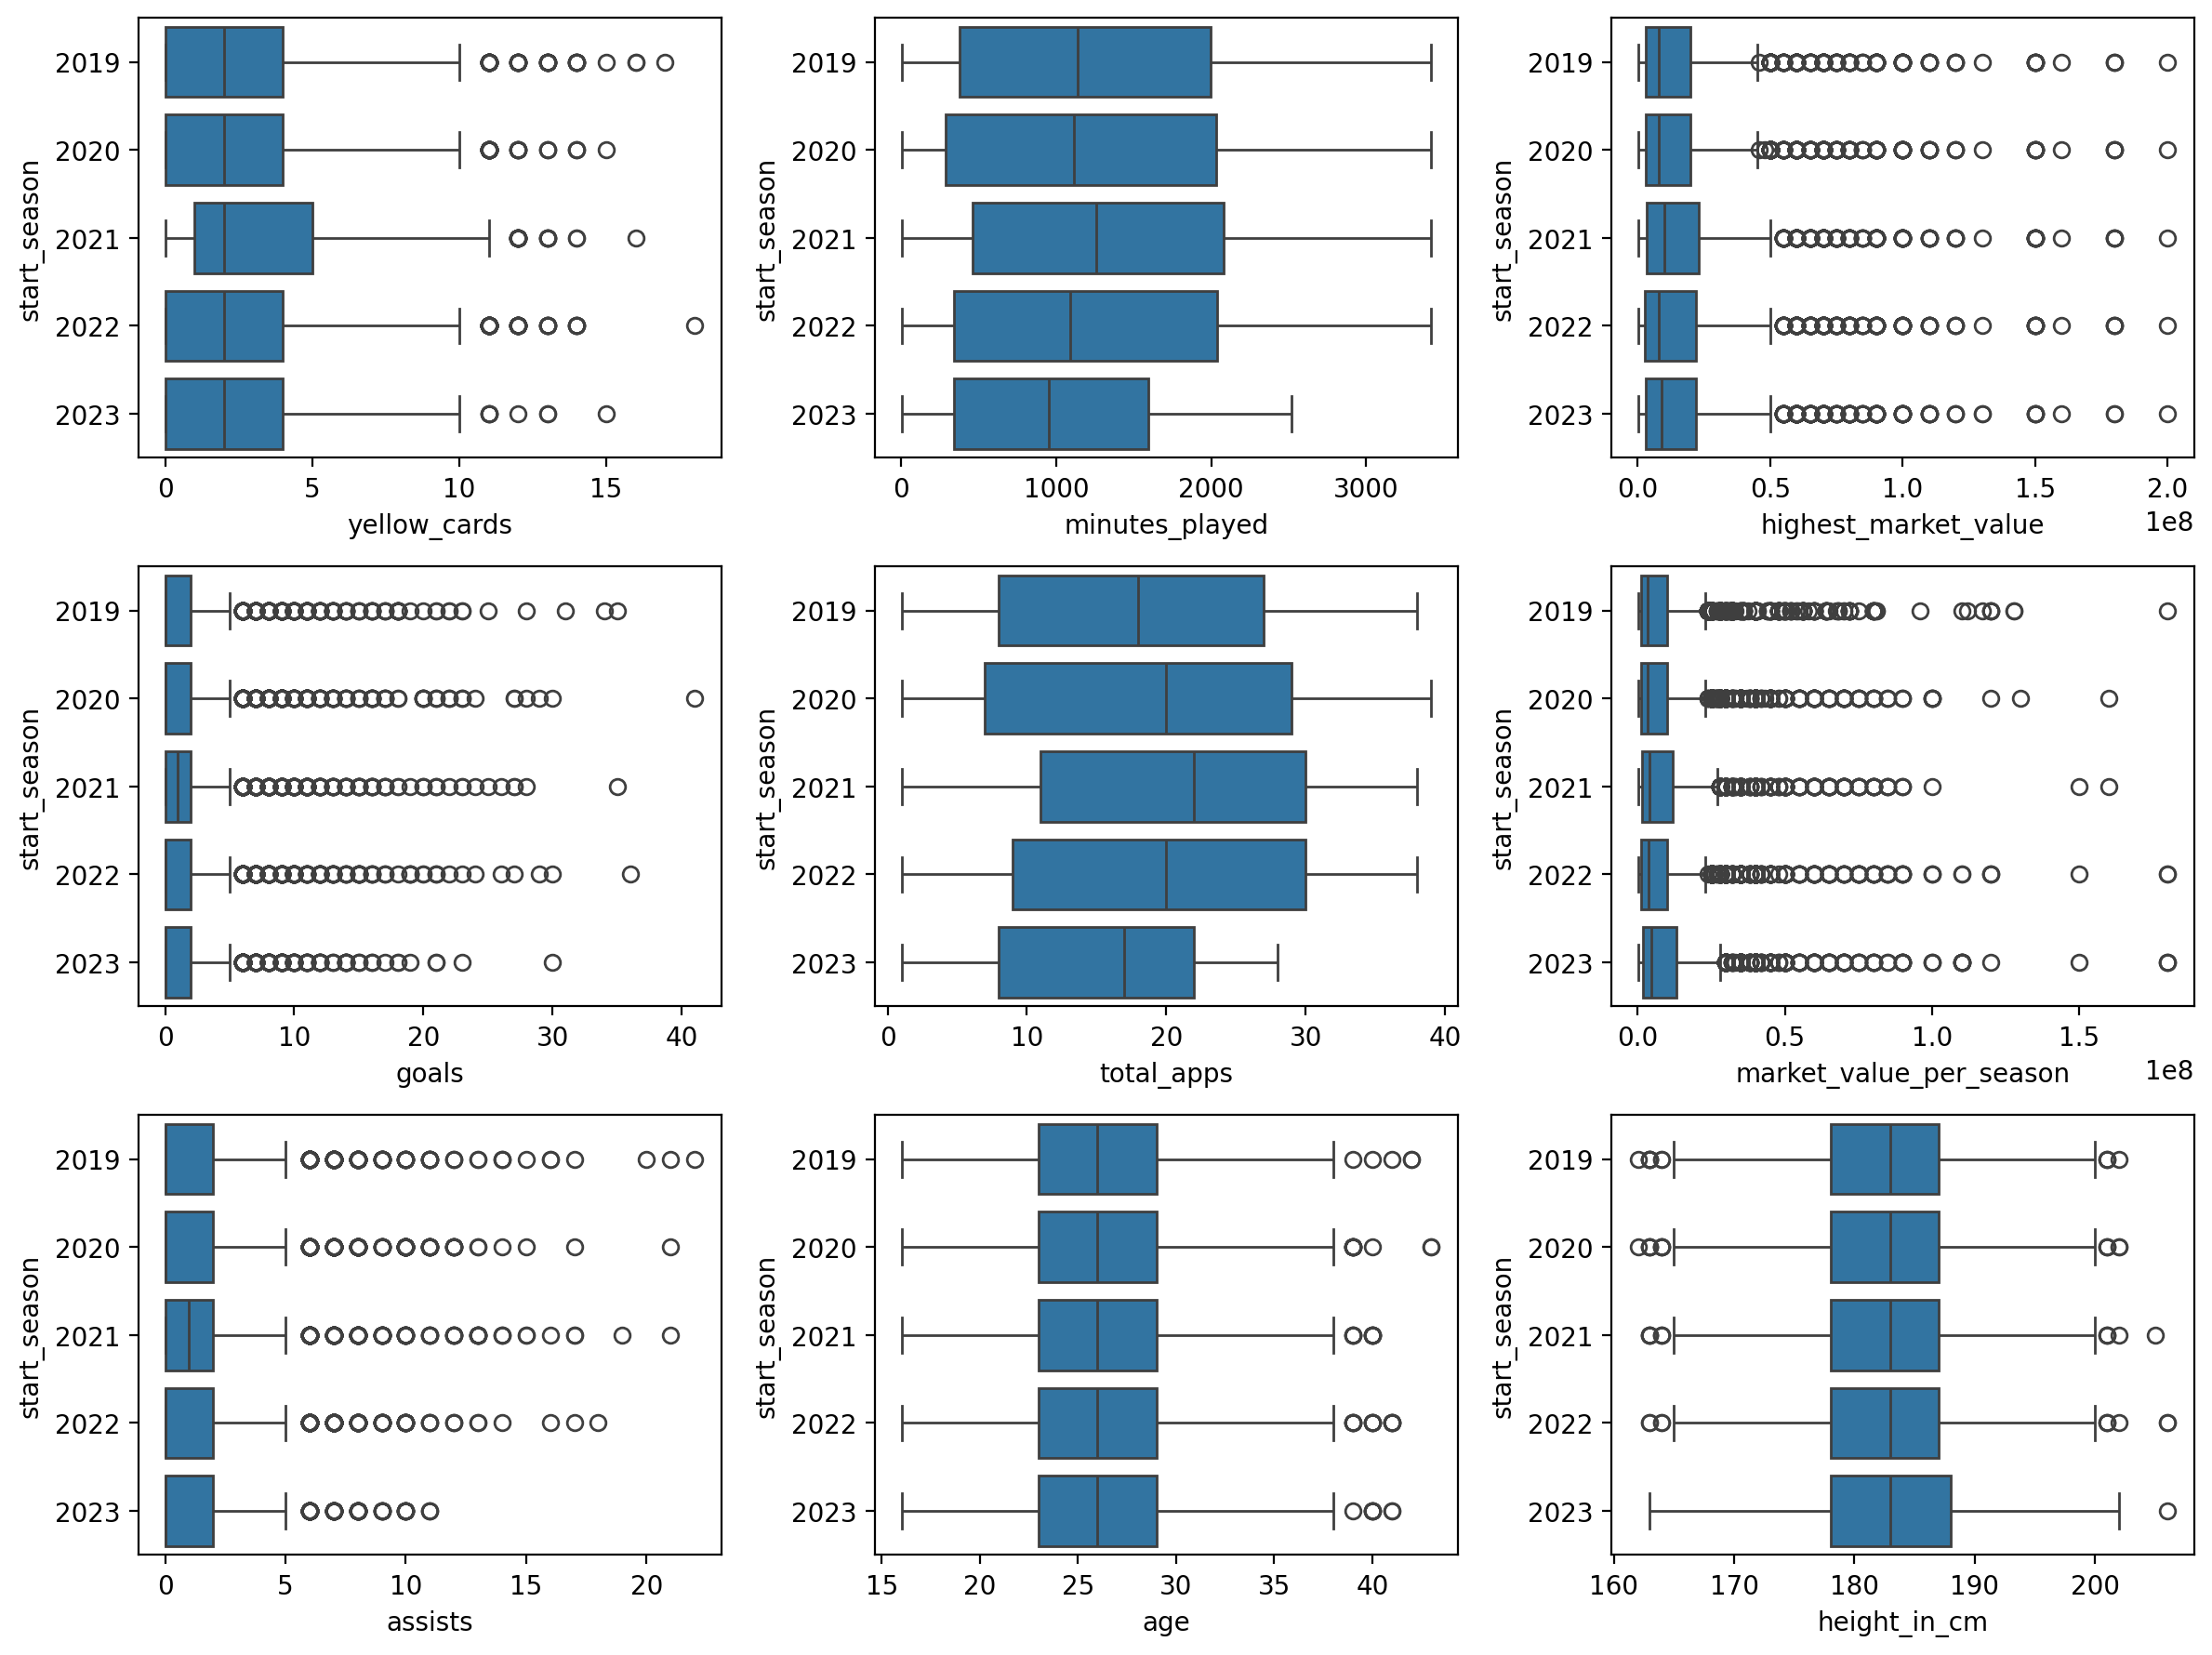

In [24]:
# num_cols에서 red_cards 제거한 것 num_cols2에 선언

num_cols2 = ['yellow_cards', 'goals', 'assists', 'minutes_played', 'total_apps', 'age', 'highest_market_value', 'market_value_per_season', 'height_in_cm']

# subplot 생성
nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 9))

# flatten()을 통해 axes를 1차원 array로 펴줘야 한다
axes = axes.T.flatten()

for col, ax in zip(num_cols2, axes):
    sns.boxplot(data=df, x=col, ax=ax, y="start_season")
    # sns.stripplot(data=df, x=col, ax=ax, y="last_season", hue="foot")

fig.tight_layout()
plt.show()

### 이상치 확인 결과
- 전반적으로 `start_season`에 따라 비슷한 결과

- `goals`, `assists`, `market_value` 등 다양한 곳에서 이상치 존재
    - 그러나 축구라는 스포츠의 특성 상, 득점, 도움, 시장 가치 등 몇몇의 특출난 선수들의 스탯이 도드라지게 나타난다
- 결론 : 이상치 따로 처리하지 않음

## Pairplot 확인

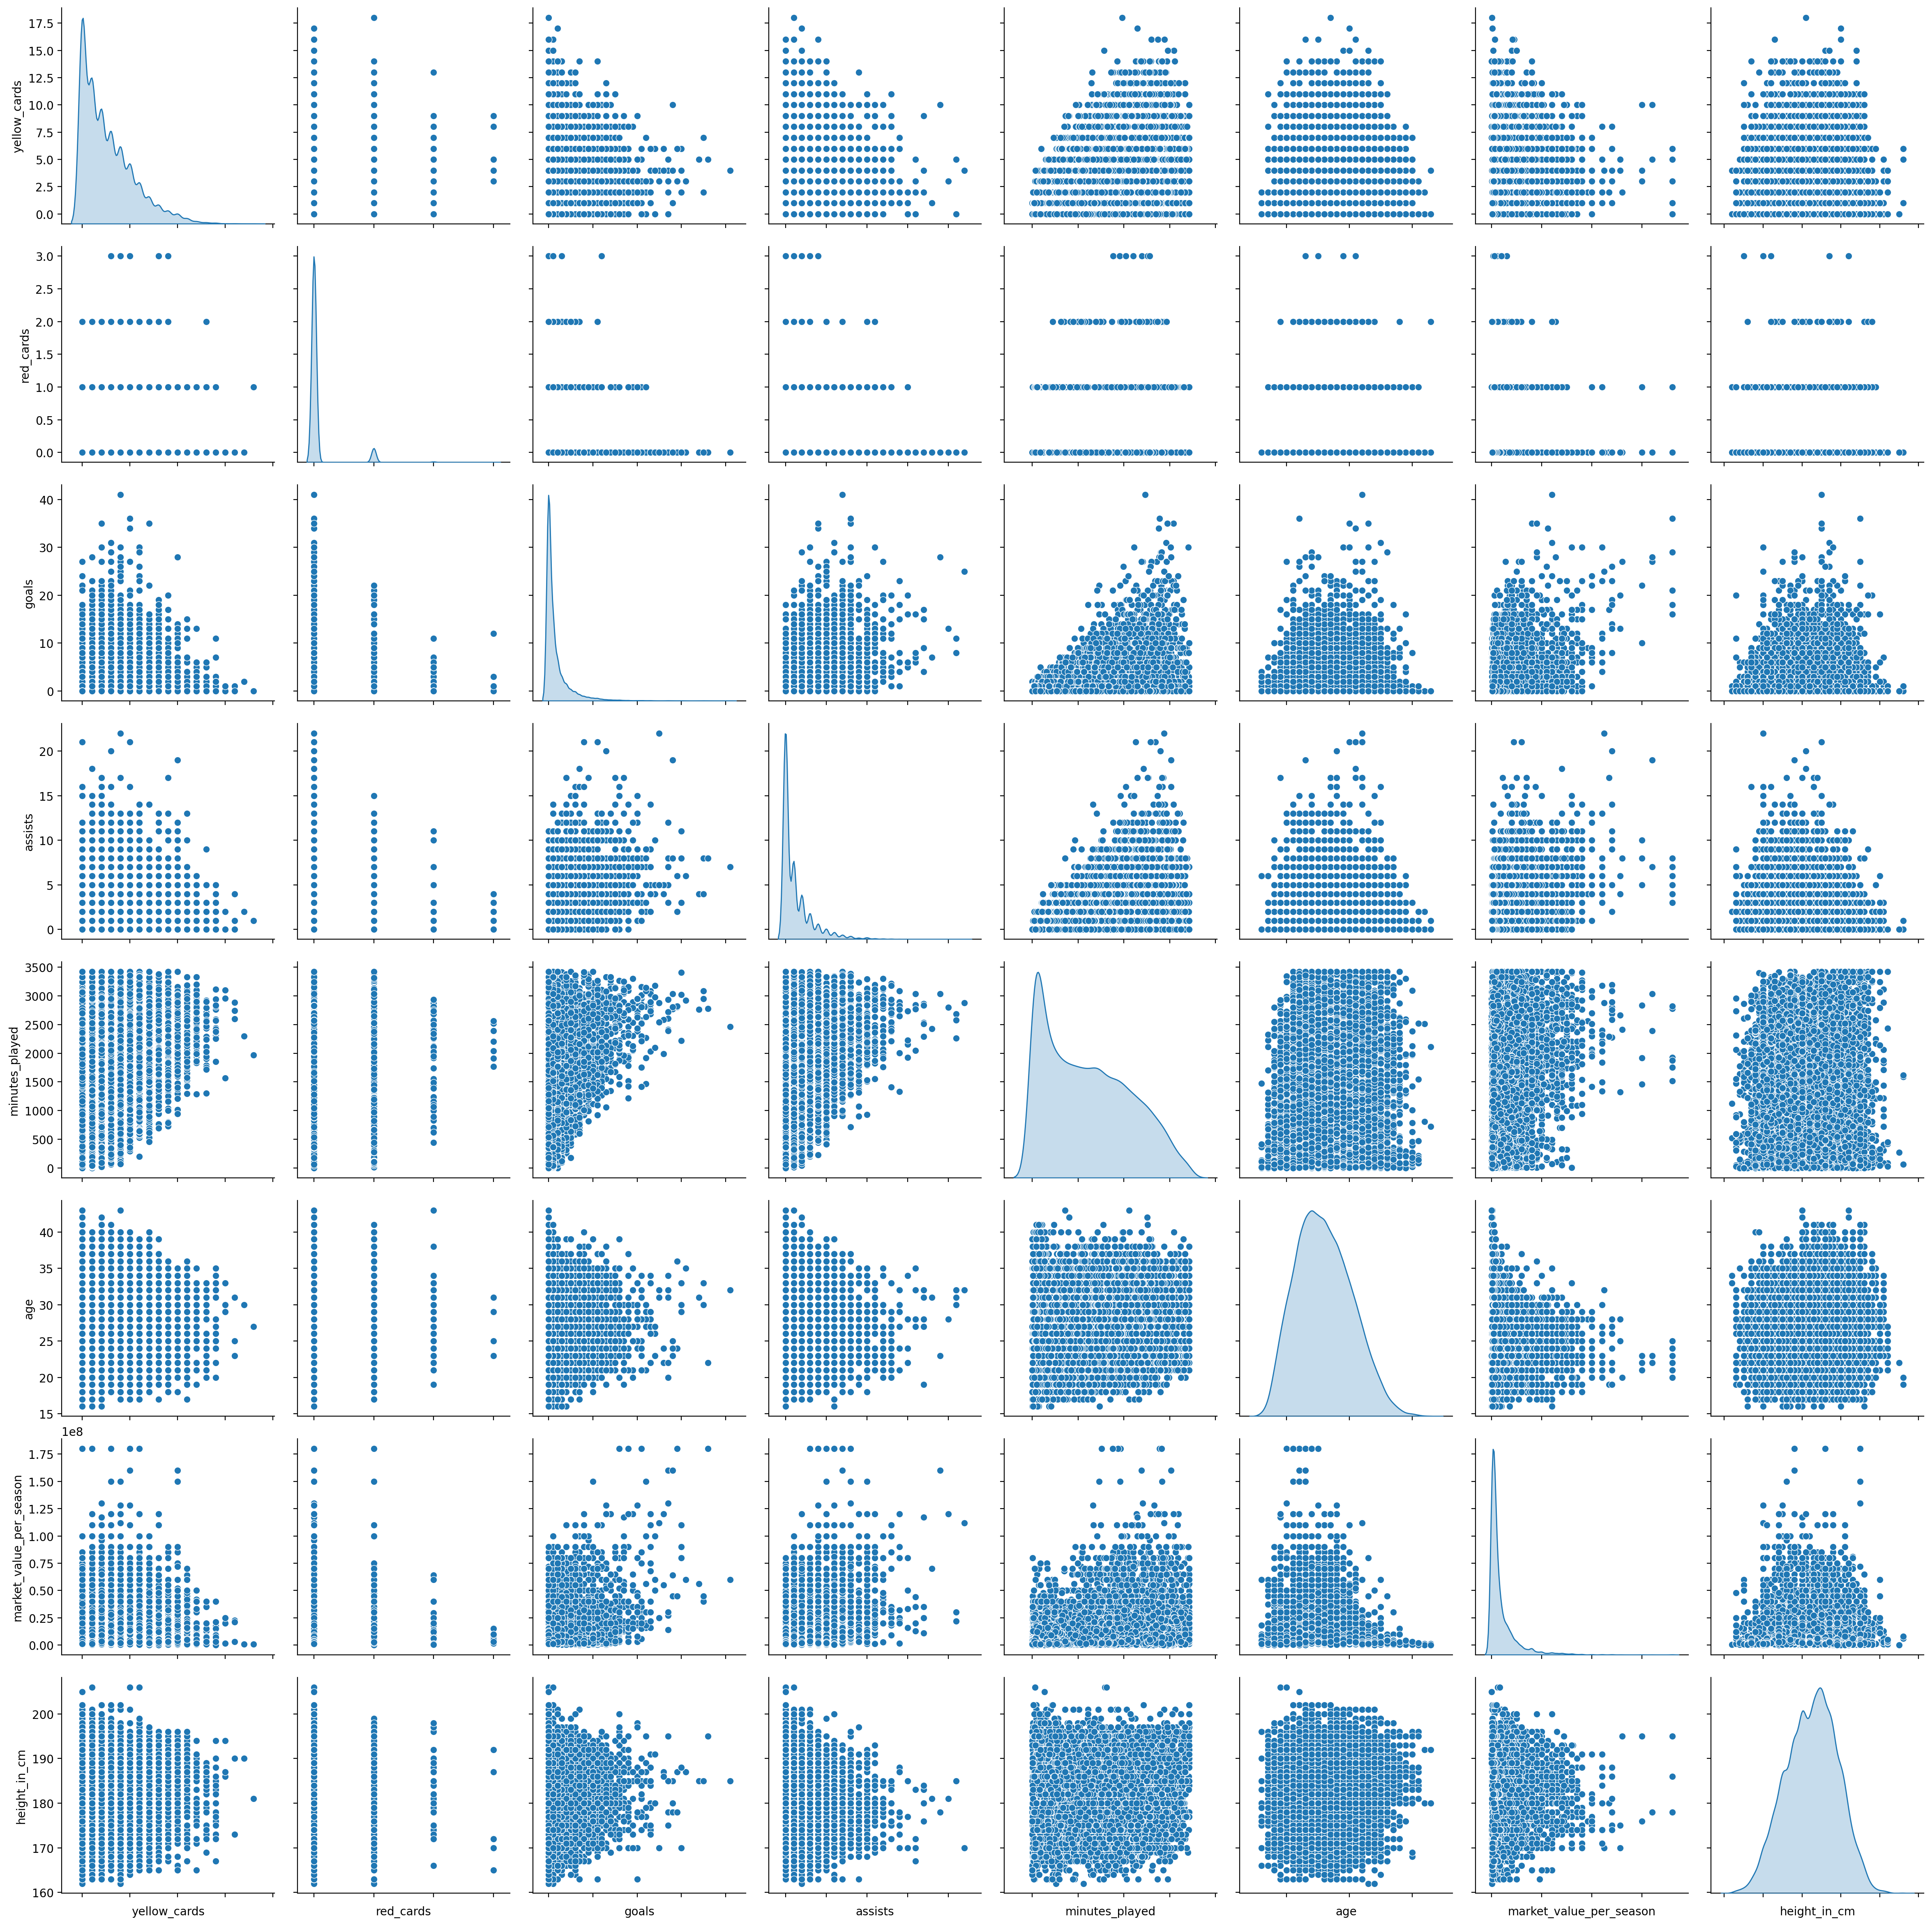

In [110]:
g = sns.pairplot(df, palette = 'seismic', diag_kind = 'kde', size=3)
g.set(xticklabels=[])

## 상관관계 확인

In [25]:
df_corr = df[num_cols].corr()

df_corr.style.background_gradient()

<Axes: >

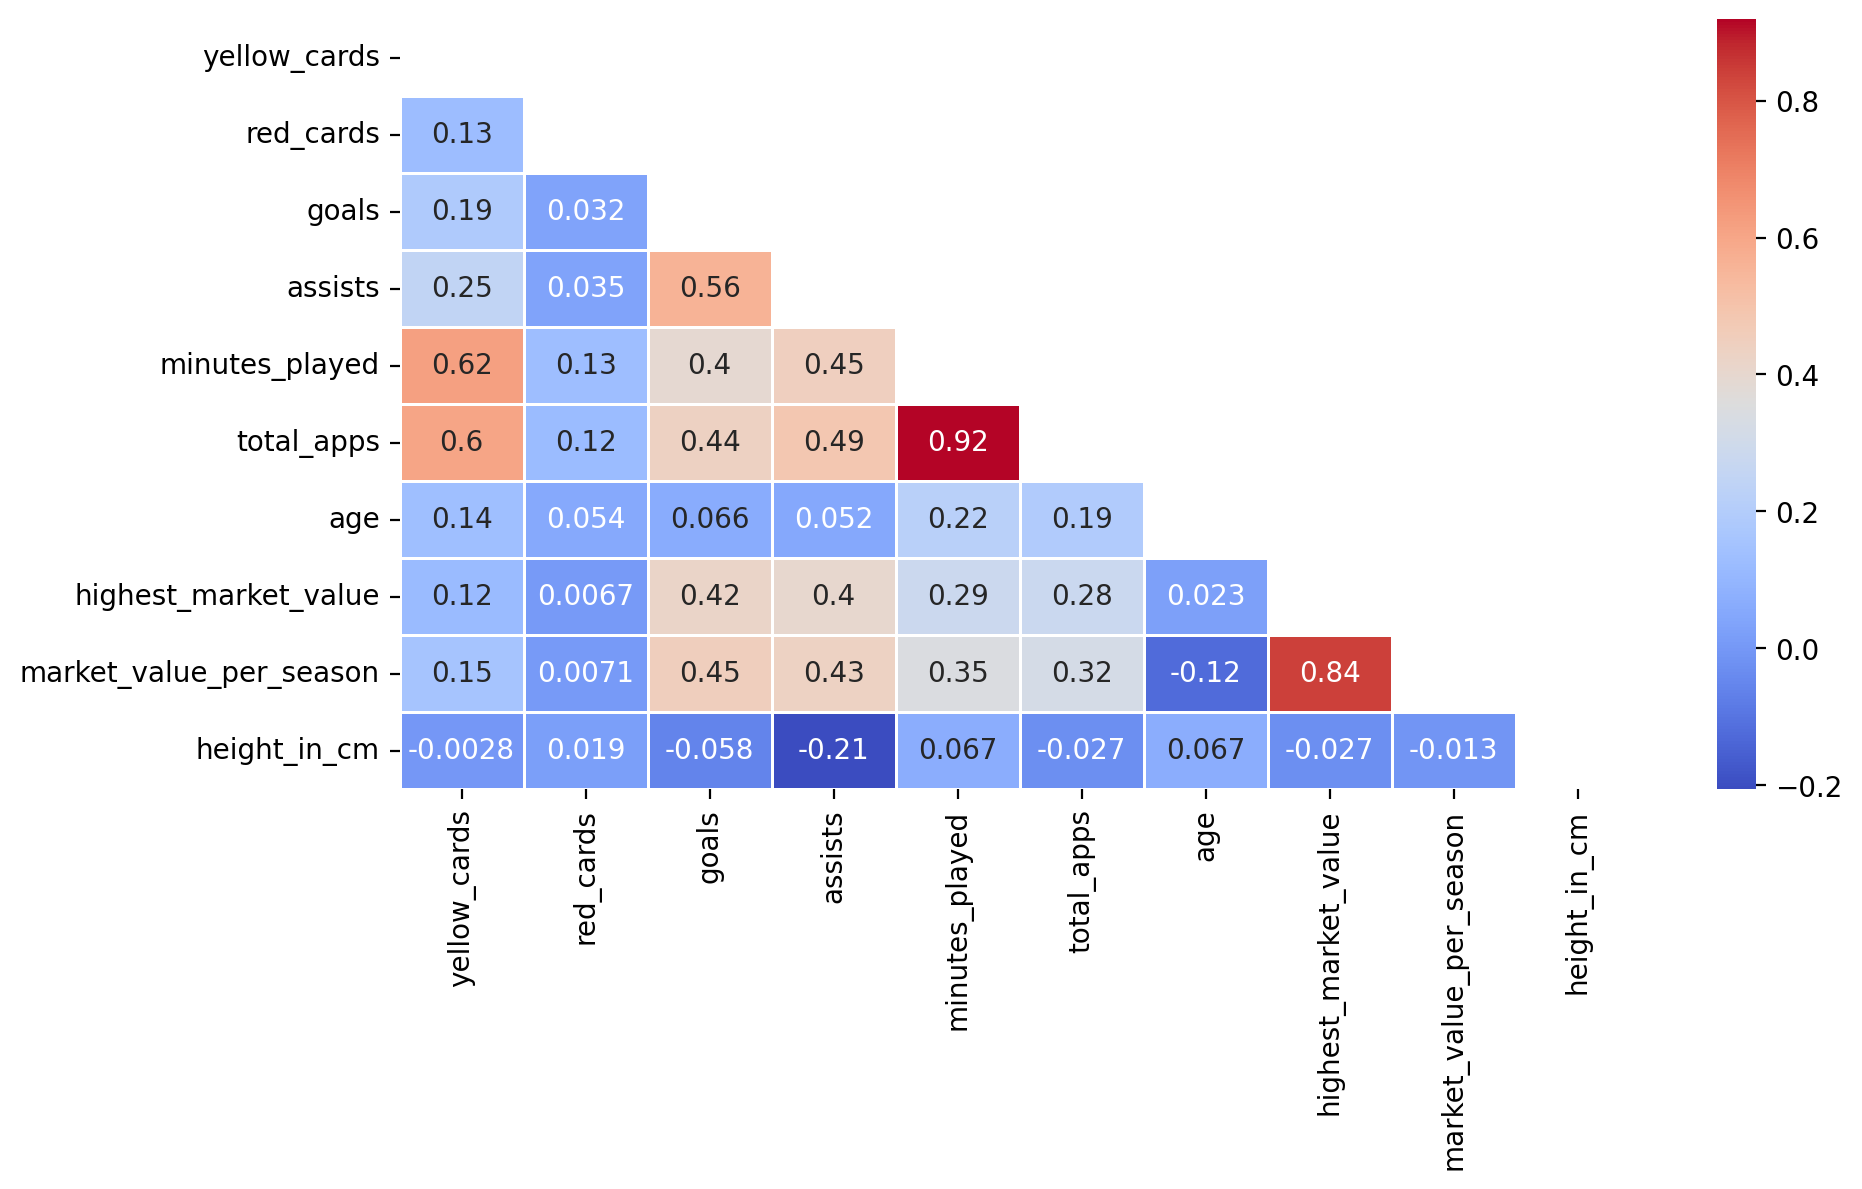

In [26]:
plt.figure(figsize=(10,5))

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(df_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_corr,
            annot=True,         # 실제 값을 표시한다
            mask=mask,          # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,      # 경계면 실선으로 구분하기
            cmap='coolwarm')

### 상관관계 결과
- 매우 강한 상관관계 (0.8 이상)
    - `minutes_played` - `total_apps`
    - `highest_market_value` - `market_value_per_season`
- 강한 상관관계 (0.6 ~ 0.8)
    - `yellow_cards` - `minutes_played`
    - `yellow_cards` - `total_apps`
- 뚜렷한 상관관계 (0.4 ~ 0.6)
    - `goals` - `market_value_per_season`
    - `goals` - `highest_market_value`
    - `goals` - `total_apps`
    - `goals` - `minutes_played`
    - `goals` - `assists`
    - `assists` - `market_value_per_season`
    - `assists` - `highest_market_value`
    - `assists` - `total_apps`
    - `assists` - `minutes_played`
- 약한 상관관계 (0.2 ~ 0.4)
    - `market_value_per_season` - `minutes_played`
    - `market_value_per_season` - `total_apps`
    - `age` - `minutes_played`
- 음의 상관관계 (-0.2 ~)
    - `assists` - `height_in_cm`

#### 상관관계 높은 변수들 분포 확인
- 상관관계가 높은 변수 관계 4가지 분포 시각화해본다

    - 매우 강한 상관관계 (0.8 이상)
        - `minutes_played` - `total_apps`
        - `highest_market_value` - `market_value_per_season`
    - 강한 상관관계 (0.6 ~ 0.8)
        - `yellow_cards` - `minutes_played`
    - 뚜렷한 상관관계 (0.4 ~ 0.6)
        - `goals` - `market_value_per_season`

In [27]:
# 상관관계 높은 변수들끼리 짝지워 high_corr에 선언
high_corr = {"minutes_played" : "total_apps", 
             "highest_market_value" : "market_value_per_season",
             "yellow_cards" : "minutes_played", 
             "goals" : "market_value_per_season"}
high_corr

{'minutes_played': 'total_apps',
 'highest_market_value': 'market_value_per_season',
 'yellow_cards': 'minutes_played',
 'goals': 'market_value_per_season'}

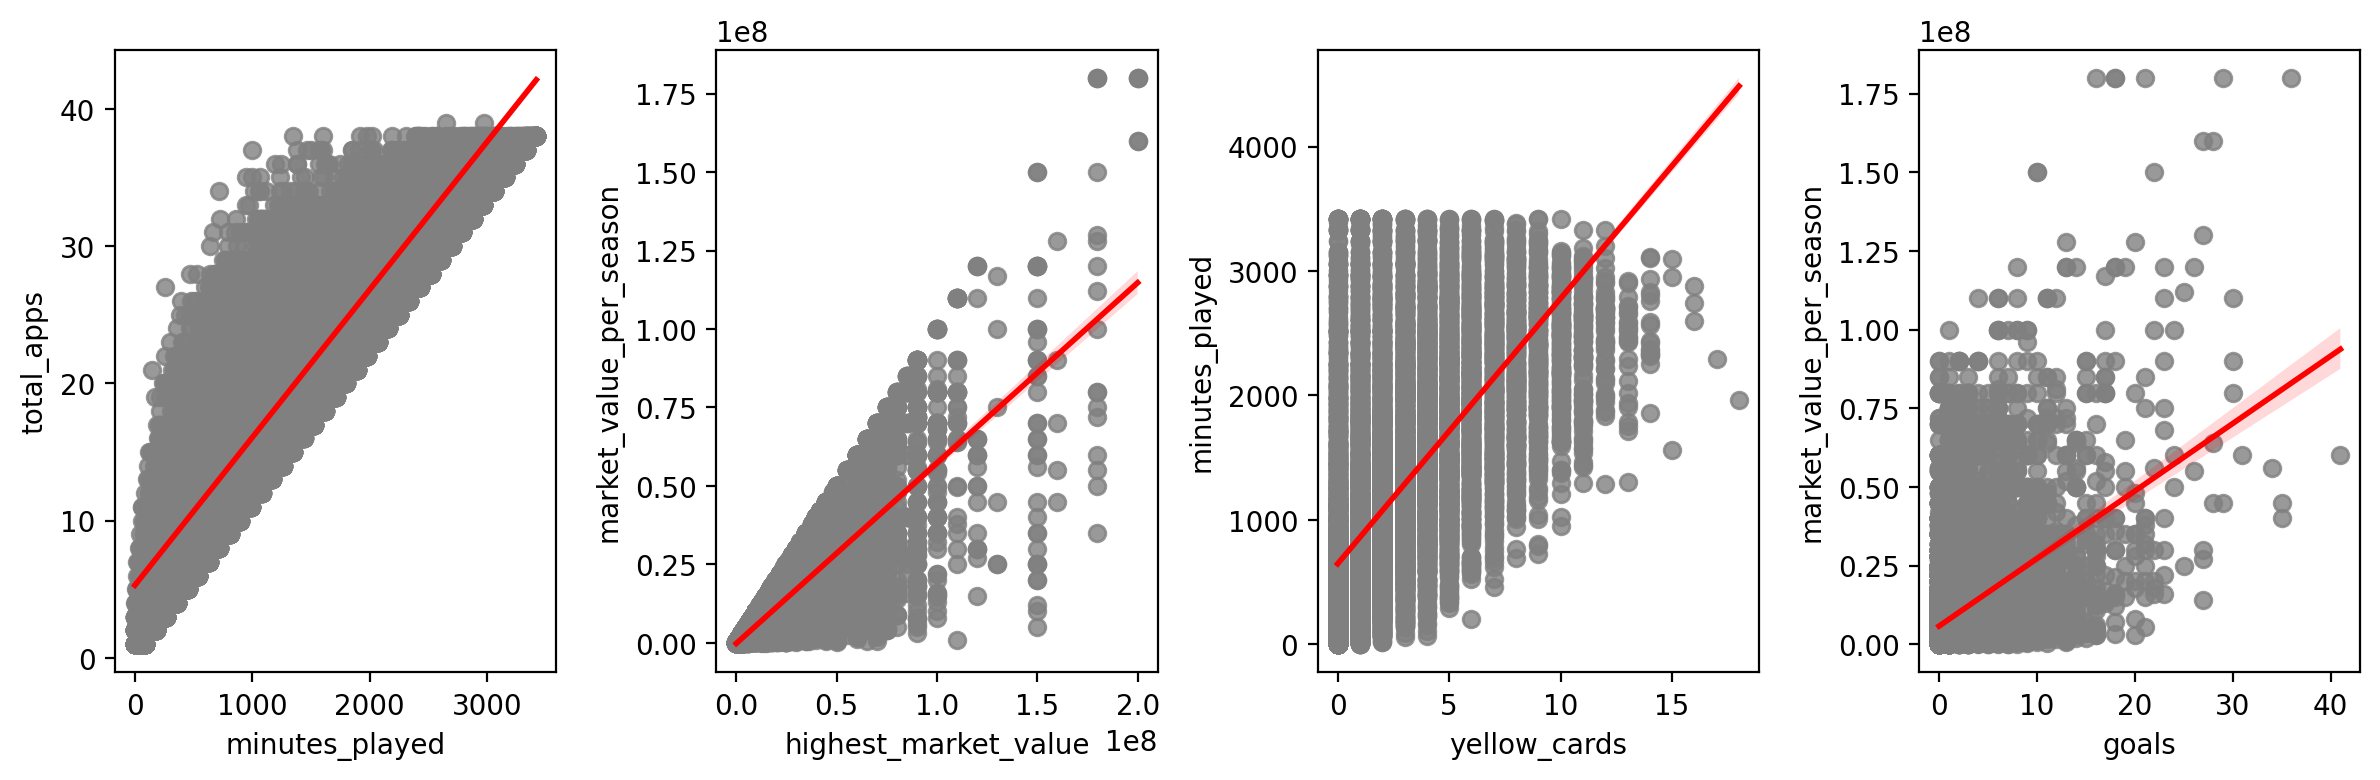

In [28]:
# 상관관계 분포 시각화
# subplot 생성
nrows, ncols = 1, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4))

# flatten()을 통해 axes를 1차원 array로 펴줘야 한다
axes = axes.T.flatten()

# regplot 그려서 추세선과 상관관계 확인
for key, ax in zip(high_corr, axes):
    sns.regplot(x=df[f"{key}"],
                y=df[high_corr[f"{key}"]],
                ax=ax,
                scatter_kws={"color":"gray"},
                line_kws={"color":"red", "lw":2})

fig.tight_layout()
plt.show()

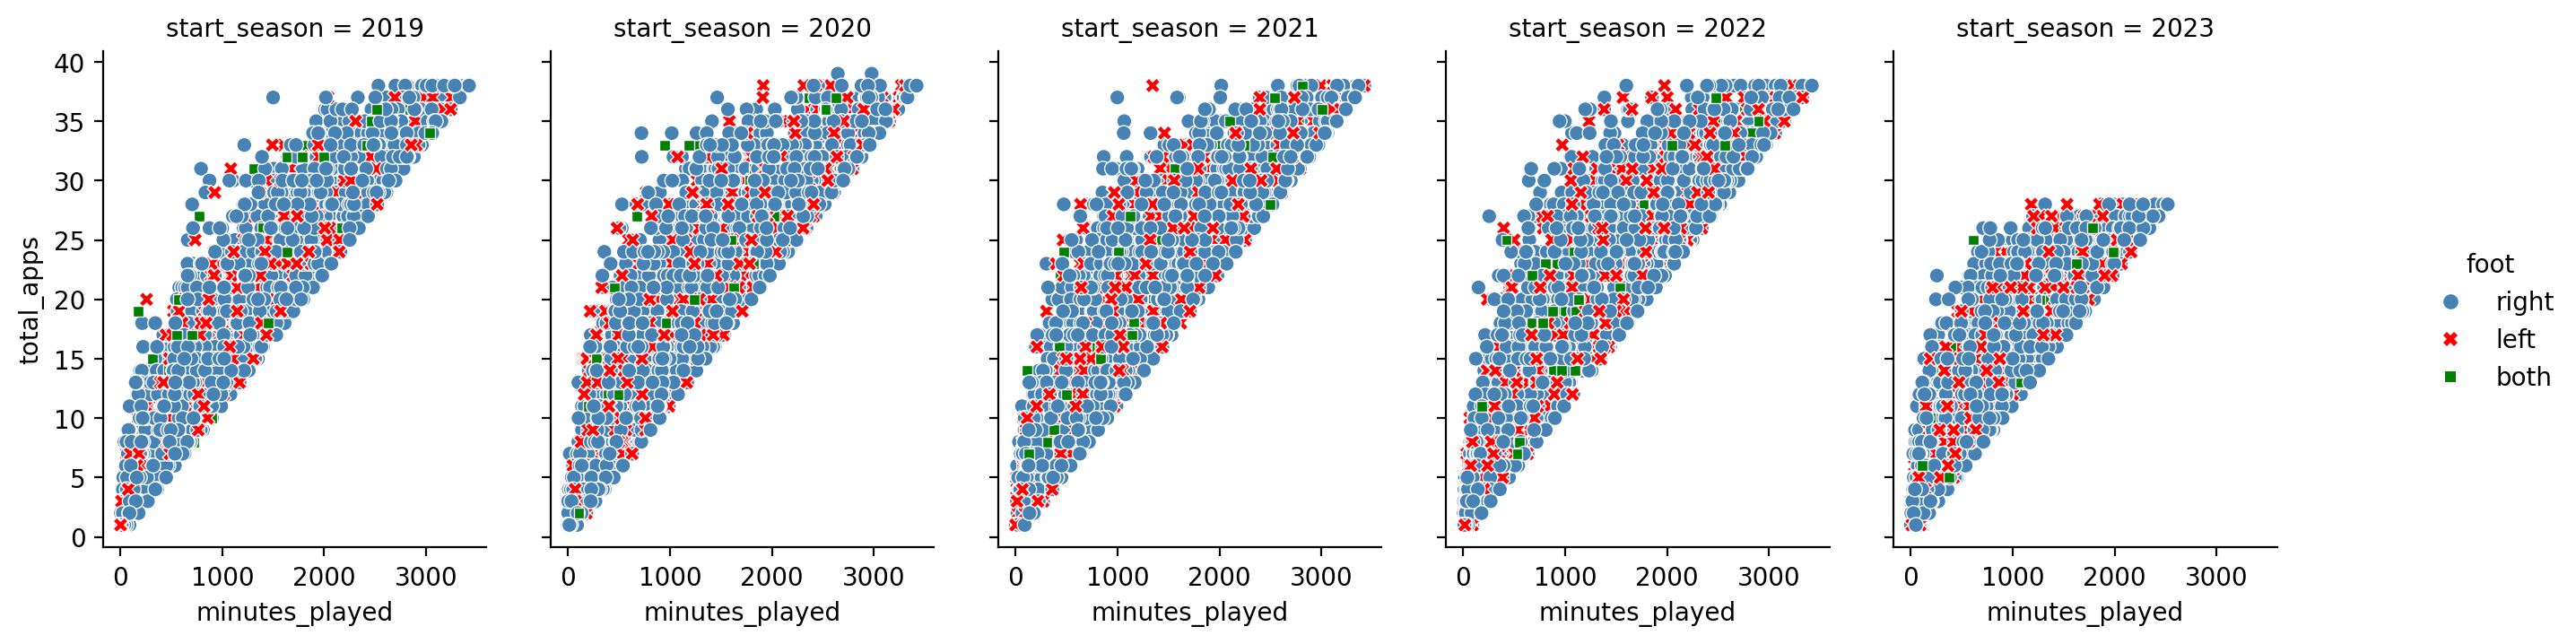

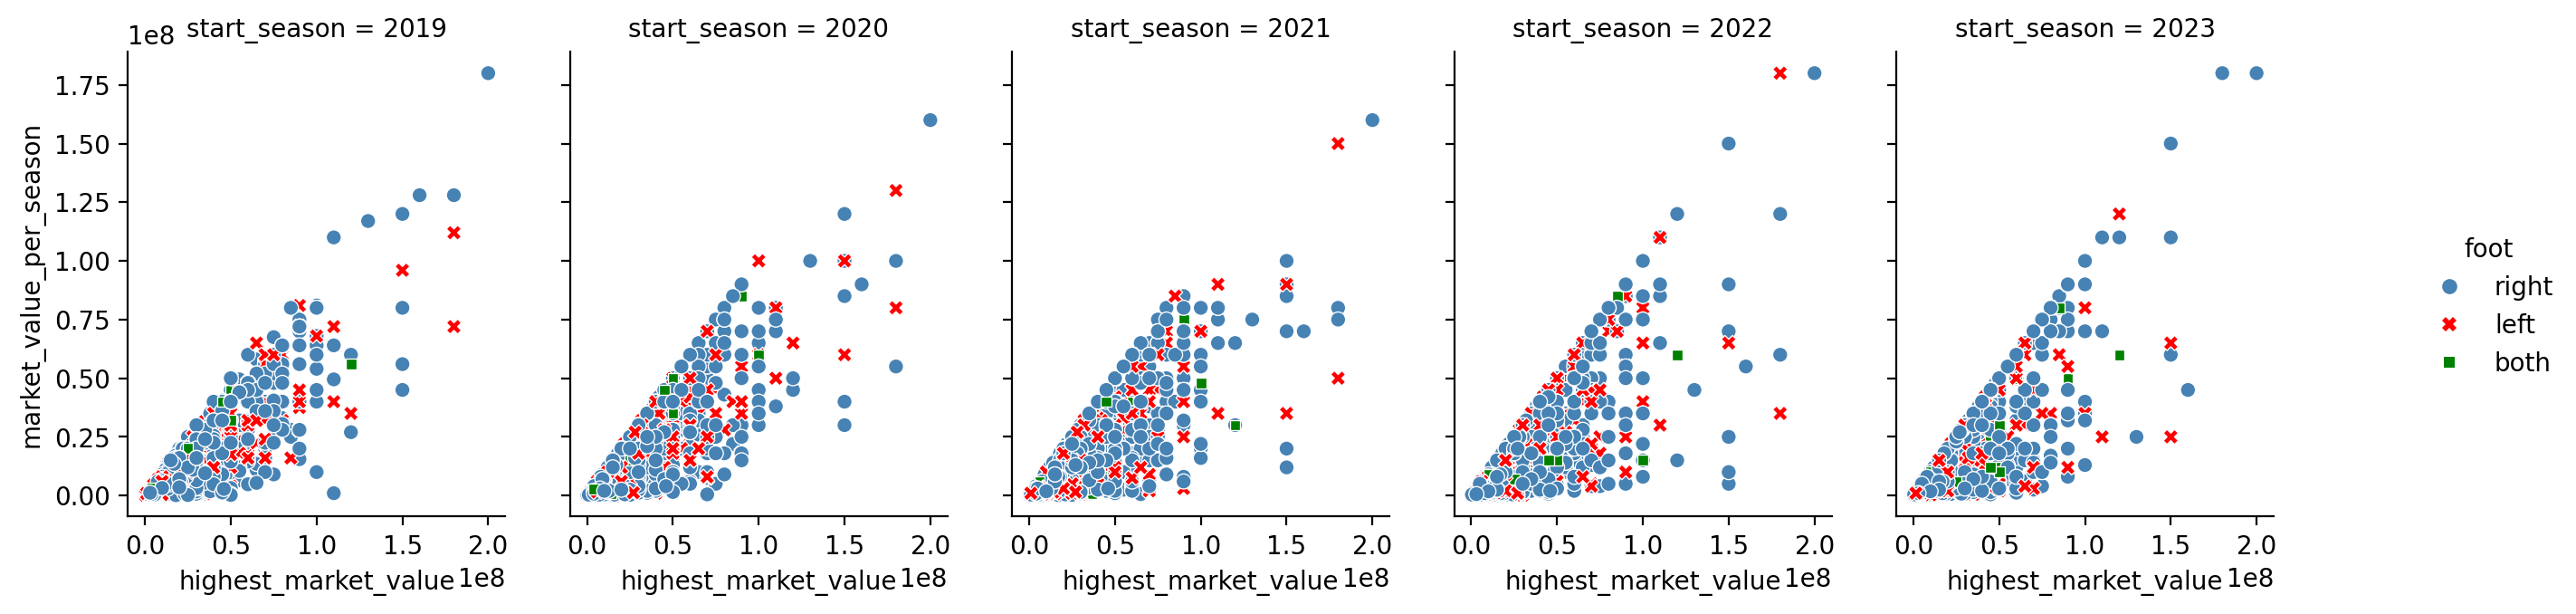

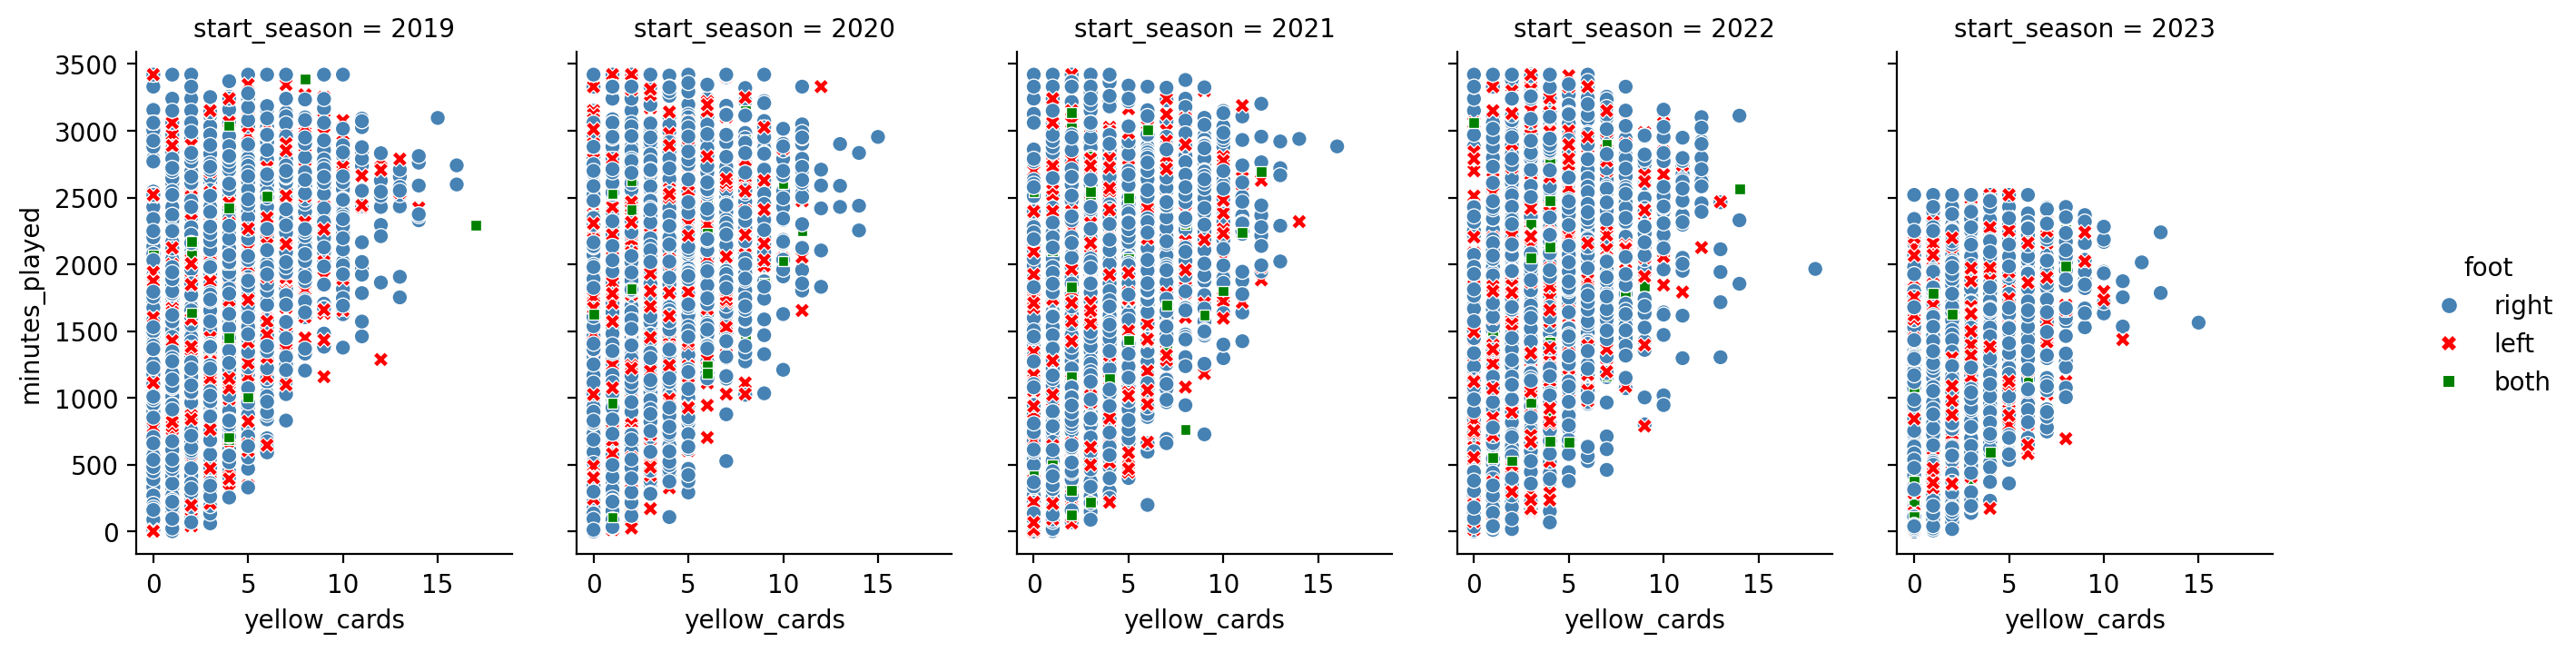

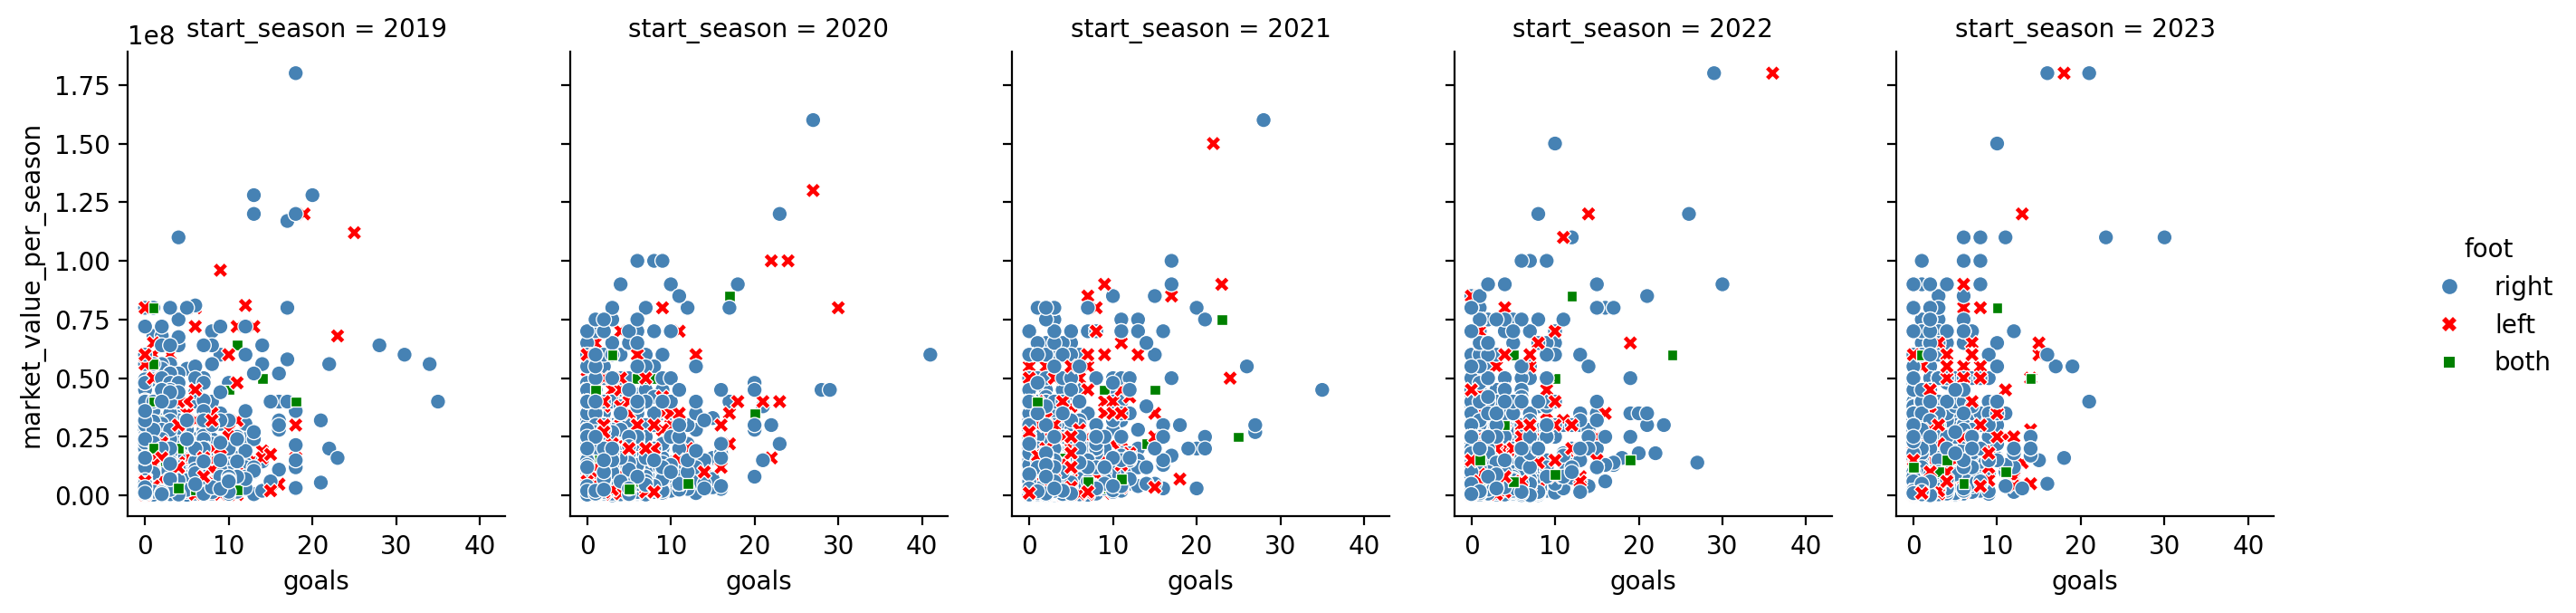

In [29]:
# sns.relplot 통해 상관계수 높은 컬럼들이 start_season에 따라 어떻게 분포가 달라지는지 확인
# 전체적으로 비슷한 모습 보인다

g1 = sns.relplot(data=df,
                 x="minutes_played",
                 y="total_apps",
                 col="start_season",
                 hue="foot",
                 style="foot", height=3, aspect=.5,
                 palette=["steelblue", "r", "g"])

g2 = sns.relplot(data=df,
                 x="highest_market_value",
                 y="market_value_per_season",
                 col="start_season",
                 hue="foot",
                 style="foot", height=3, aspect=.5,
                 palette=["steelblue", "r", "g"])

g3 = sns.relplot(data=df,
                 x="yellow_cards",
                 y="minutes_played",
                 col="start_season",
                 hue="foot",
                 style="foot", height=3, aspect=.5,
                 palette=["steelblue", "r", "g"])

g4 = sns.relplot(data=df,
                 x="goals",
                 y="market_value_per_season",
                 col="start_season",
                 hue="foot",
                 style="foot",height=3, aspect=.5,
                 palette=["steelblue", "r", "g"])

g1.fig.set_size_inches(15, 4)
g2.fig.set_size_inches(15, 4)
g3.fig.set_size_inches(15, 4)
g4.fig.set_size_inches(15, 4)

## 다중 공선성
- 하나의 독립 변수가 여러개의 독립 변수들로 잘 예측되는 경우를 의미한다
- 독립 변수들이 서로 독립이 아니라, 상호 상관관계가 강한 경우 발생
- 일반적으로 어떤 독립 변수의 영향력을 파악할 때, 확인하려는 변수의 영향력만을 판단하기 위해 다른 독립 변수들은 모두 일정하다고 가정한다.
- 그러나 만약 두 독립 변수가 서로에게 영향을 주고 있다면, 하나의 영향력을 검증할 때 다른 하나의 영향력을 완전히 통제할 수 없게 된다
    - 이러한 상황에서는 도출된 해석이 타당하다고 볼 수 없다
    
- 다중 공선성이 존재한다면 모델 구축 시 발생하는 상황
    - 계수 추정이 잘 되지 않거나, 불안정해져서 데이터가 약간만 바뀌어도 추정치 크게 달라짐
    - 계수가 통계적으로 유의미하지 않은 것처럼 도출
    - 과적합의 위험성
    - 특히 회귀 분석에 큰 영향 미친다 (분류는 영향 크게 미칠때도 있고 별로 상관 없을 때도 있음)
- References
    - https://dacon.io/codeshare/4443
    - https://datascienceschool.net/03%20machine%20learning/06.04%20%EB%8B%A4%EC%A4%91%EA%B3%B5%EC%84%A0%EC%84%B1%EA%B3%BC%20%EB%B3%80%EC%88%98%20%EC%84%A0%ED%83%9D.html
    - https://dacon.io/forum/408387

### 다중 공선성 진단
- 분산팽창계수 (VIF, Variance Inflation Factor)를 구한다
- 일반적으로 5 또는 10보다 크면 다중 공선성이 있다고 판단한다

- VIF : 독립변수를 다른 독립변수로 선형회귀한 성능을 나타낸 지표
    - 다른 변수에 의존적일 수록 VIF가 증가

In [30]:
# 출처 : https://aliencoder.tistory.com/17

def feature_engineering_XbyVIF(df):
    vif = pd.DataFrame()

    # df의 컬럼 개수만큼 variance_inflation_factor를 구한다
    vif['VIF_Factor'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    # df의 컬럼 이름을 vif의 Feature 열에 넣어준다
    vif['Feature'] = df.columns
    return vif

vif = feature_engineering_XbyVIF(df[num_cols])
print(vif)

   VIF_Factor                  Feature
0    3.305971             yellow_cards
1    1.091263                red_cards
2    2.138460                    goals
3    2.381593                  assists
4   18.812991           minutes_played
5   26.744507               total_apps
6   40.995147                      age
7    5.954579     highest_market_value
8    5.901704  market_value_per_season
9   39.977066             height_in_cm


### 다중 공선성 해결 방법
- 다중 공선성을 갖는 독립 변수 중 하나 혹은 일부를 제거한다
    - 단 회귀 모형의 R-square 값을 유지 또는 개선시키는 방향으로만 수행해야 한다
- 변수를 변형시키거나 새로운 관측치를 이용한다
- 자료를 수집하는 현장의 상황을 보아 상관관계의 이유를 파악하여 해결한다
- 주성분 분석 (Principle Component Analysis, PCA)을 이용한 diagonal matrix의 형태로 공선성을 없애준다

- References
    - https://aliencoder.tistory.com/17

#### 다중 공선성 결론
- 회귀 모델을 생성할 때, 높은 VIF 수치를 보이는 `minutes_played` - `total_apps` (상관계수 0.92) 컬럼을 지우거나 변형, 개선한다

- 높은 다중 공선성 보이는 또 다른 컬럼 `age`는 남긴다
    - VIF가 크더라도 분석에 꼭 필요한 Feature라면 살리는 것이 좋다
    - references
        - https://recipesds.tistory.com/entry/%EC%9C%A0%EC%9D%98%ED%95%98%EC%A7%80-%EC%95%8A%EC%9D%80-%EA%B3%84%EC%88%98%EB%A5%BC-%EC%96%B4%EC%A9%90%EB%8B%A4-%EA%B1%8D-%EB%B2%84%EB%A6%B4%EA%B9%8C-%EB%8B%A4%EC%A4%91%EA%B3%B5%EC%84%A0%EC%84%B1%EC%9D%80-%EC%95%85%EB%8B%B9%EC%9D%BC%EA%B9%8C-%EC%83%81%EA%B4%80%EC%9D%B4%EB%82%98-VIF%EB%86%92%EC%9C%BC%EB%A9%B4-%EB%8B%A4-%EC%97%86%EC%95%A8%EA%B9%8C
        

In [39]:
num_cols

['yellow_cards',
 'red_cards',
 'goals',
 'assists',
 'minutes_played',
 'total_apps',
 'age',
 'highest_market_value',
 'market_value_per_season',
 'height_in_cm']

In [40]:
# 수치형 변수 num_cols에서, 높은 VIF 수치를 보이는 total_apps 제거한 후 VIF 확인
df_no_apps = df.drop("total_apps", axis="columns")
feature_engineering_XbyVIF(df_no_apps[['yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played', 'age',
                                       'highest_market_value','market_value_per_season', 'height_in_cm']])

VIF_Factor                  Feature
0    3.245851             yellow_cards
1    1.091215                red_cards
2    2.090805                    goals
3    2.316499                  assists
4    5.783975           minutes_played
5   40.990590                      age
6    5.937428     highest_market_value
7    5.838238  market_value_per_season
8   38.327066             height_in_cm

In [41]:
# 수치형 변수 num_cols에서, 높은 VIF 수치를 보이는 total_apps, highest_market_value 제거한 후 VIF 확인
# → market_value_per_season 수치 감소 (약 5.2 → 1.9)
feature_engineering_XbyVIF(df_no_apps[['yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played', 
                                       'age', 'market_value_per_season', 'height_in_cm']])

VIF_Factor                  Feature
0    3.244475             yellow_cards
1    1.091215                red_cards
2    2.086972                    goals
3    2.310665                  assists
4    5.751986           minutes_played
5   38.402589                      age
6    2.022143  market_value_per_season
7   37.230363             height_in_cm

In [42]:
# total_apps, highest_market_value 제거한 데이터프레임을 df에 선언
# → 다중 공선성 해결
df = df.drop(["total_apps", "highest_market_value"], axis=1)
df.head(3)

player_name start_season  yellow_cards  red_cards  goals  assists  \
0  Aaron Connolly         2019             0          0      3        2   
1  Aaron Connolly         2020             0          0      2        1   
2  Aaron Connolly         2021             0          0      0        0   

   minutes_played competition_code date_of_birth  age        position  \
0            1261   premier-league    2000-01-28   20  Centre-Forward   
1             791   premier-league    2000-01-28   21  Centre-Forward   
2             155   premier-league    2000-01-28   22  Centre-Forward   

                        current_club_name  market_value_per_season  country  \
0  Brighton and Hove Albion Football Club                4000000.0  Ireland   
1  Brighton and Hove Albion Football Club                7000000.0  Ireland   
2  Brighton and Hove Albion Football Club                6000000.0  Ireland   

    foot  height_in_cm  
0  right         174.0  
1  right         174.0  
2  right         174.0

## `column`별 분석

<Axes: xlabel='age', ylabel='market_value_per_season'>

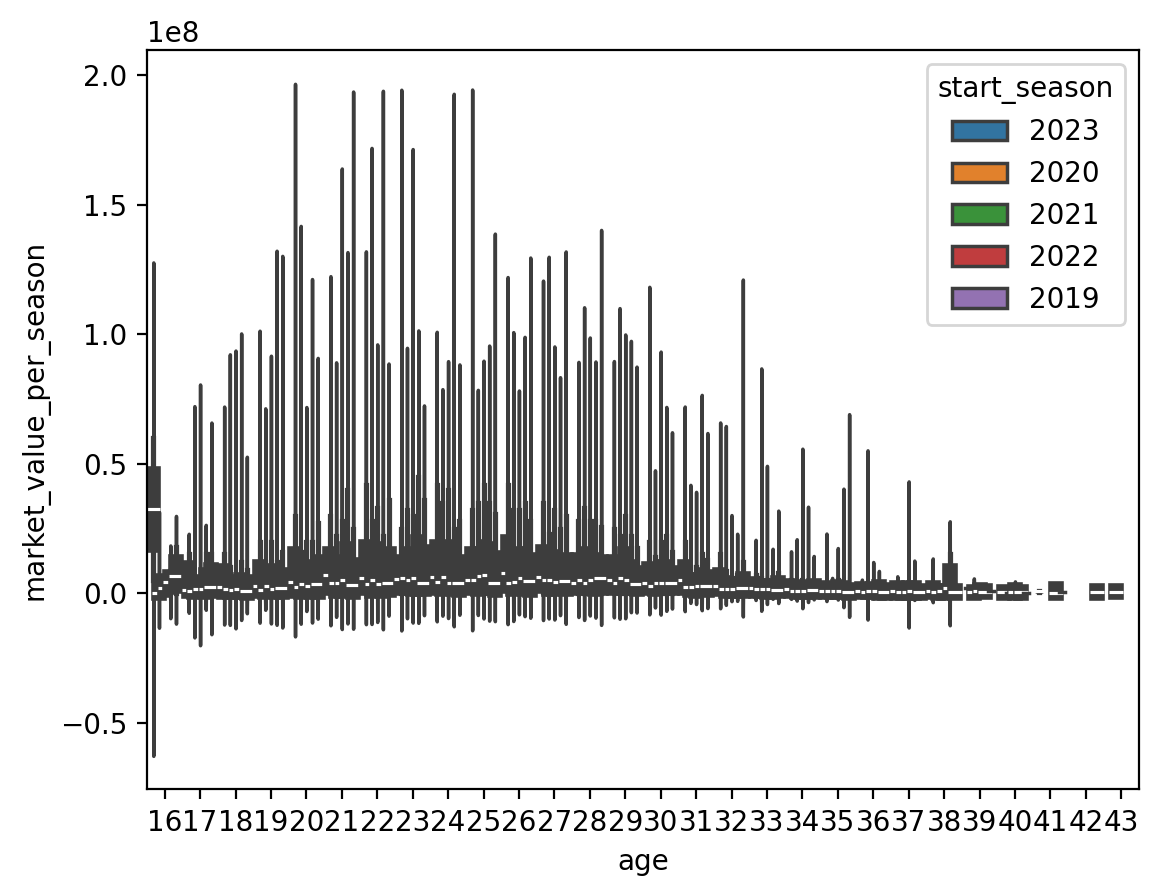

In [111]:
sns.violinplot(data=df, x="age", y="market_value_per_season", hue="start_season")

### `goals`, `assists` 분석

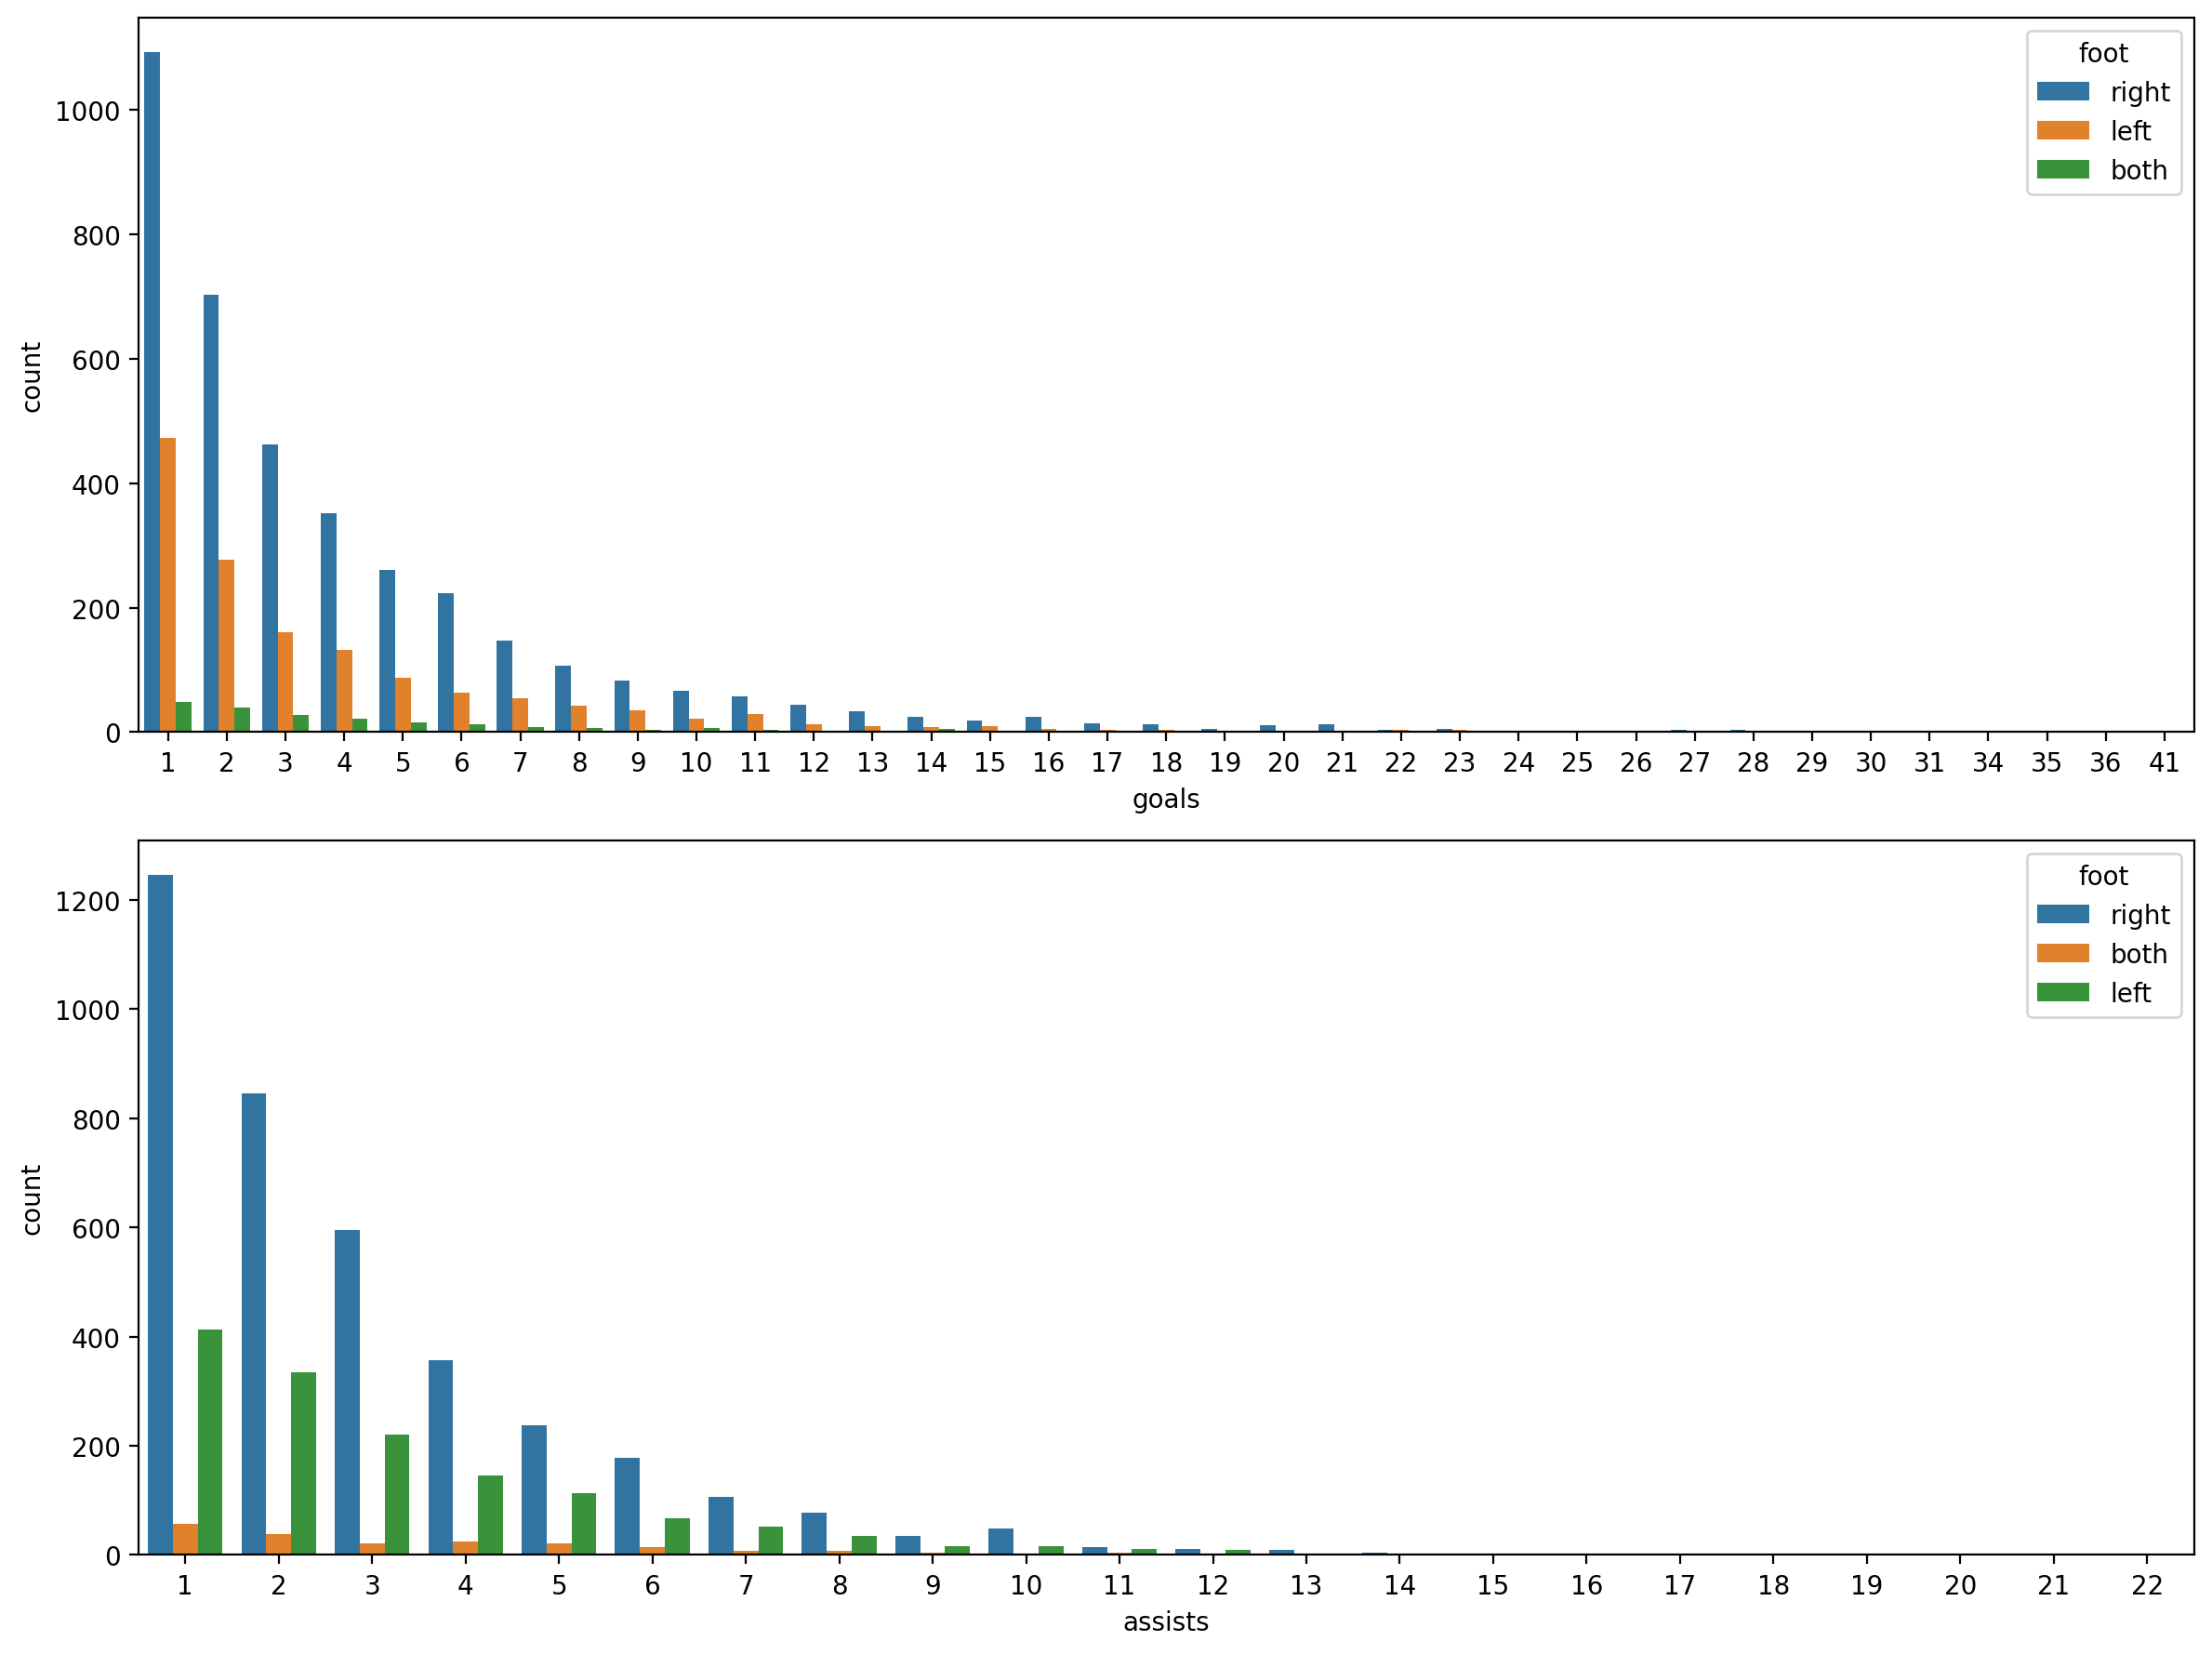

In [43]:
goals_assists = ["goals", "assists"]
more_than_zero = (df.goals>0) & (df.assists>0)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 9))

for col, ax in zip(goals_assists, axes):
    sns.countplot(data=df[more_than_zero], x=col, ax=ax, hue="foot")

fig.tight_layout()

plt.show()

In [44]:
# 41 득점한 선수 확인
df[df.goals==41]

player_name start_season  yellow_cards  red_cards  goals  \
12858  Robert Lewandowski         2020             4          0     41   

       assists  minutes_played competition_code date_of_birth  age  \
12858        7            2463       bundesliga    1988-08-21   32   

             position      current_club_name  market_value_per_season country  \
12858  Centre-Forward  Futbol Club Barcelona               60000000.0  Poland   

        foot  height_in_cm  
12858  right         185.0

In [45]:
# 22 어시스트한 선수 확인
df[df.assists==22]

player_name start_season  yellow_cards  red_cards  goals  assists  \
8652  Lionel Messi         2019             4          0     25       22   

      minutes_played competition_code date_of_birth  age      position  \
8652            2880           laliga    1987-06-24   32  Right Winger   

                      current_club_name  market_value_per_season    country  \
8652  Paris Saint-Germain Football Club              112000000.0  Argentina   

      foot  height_in_cm  
8652  left         170.0

#### 시즌별 Goals, Assists Top 10 확인

In [46]:
func1 = lambda g: g.sort_values(by="goals", ascending=False)[:10]
func2 = lambda g: g.sort_values(by="assists", ascending=False)[:10]

In [47]:
goal_top10 = df.groupby("start_season")[["player_name", "goals", "assists"]].apply(func1)
goal_top10.head()

player_name  goals  assists
start_season                                          
2019         2681        Ciro Immobile     35        8
             12857  Robert Lewandowski     34        4
             2836    Cristiano Ronaldo     31        6
             14657         Timo Werner     28        8
             8652         Lionel Messi     25       22

In [48]:
assist_top10 = df.groupby("start_season")[["player_name", "goals", "assists"]].apply(func2)
assist_top10.head()

player_name  goals  assists
start_season                                       
2019         8652      Lionel Messi     25       22
             14530    Thomas Müller      8       21
             8066   Kevin De Bruyne     13       20
             6319      Jadon Sancho     17       17
             9003      Luis Alberto      6       16

In [49]:
goals_assists_top10 = pd.concat([goal_top10, assist_top10]).reset_index()
goals_assists_top10.head()

start_season  level_1         player_name  goals  assists
0         2019     2681       Ciro Immobile     35        8
1         2019    12857  Robert Lewandowski     34        4
2         2019     2836   Cristiano Ronaldo     31        6
3         2019    14657         Timo Werner     28        8
4         2019     8652        Lionel Messi     25       22

##### 시각화 (`plotly`)

In [50]:
# plotly로 scatterplot 확인
import plotly.express as px

fig = px.scatter(data_frame=goals_assists_top10, x="goals", y="assists", color="player_name", 
                 size="goals", facet_row="start_season",
                 width=1200, height=2000)

fig.update_layout(title_text="Scatterplot by Goals and Assists per Season")
# fig.update_traces(textposition="top right")
fig.show()

#### 5경기 이상 뛴 선수들로 시즌별 Goals, Assists Top 10 확인

In [51]:
df_over_5_games = df[df.minutes_played>=450]
df_over_5_games.head()

player_name start_season  yellow_cards  red_cards  goals  assists  \
0   Aaron Connolly         2019             0          0      3        2   
1   Aaron Connolly         2020             0          0      2        1   
3  Aaron Cresswell         2019             7          0      3        0   
4  Aaron Cresswell         2020             3          0      0        8   
5  Aaron Cresswell         2021             3          0      2        3   

   minutes_played competition_code date_of_birth  age        position  \
0            1261   premier-league    2000-01-28   20  Centre-Forward   
1             791   premier-league    2000-01-28   21  Centre-Forward   
3            2730   premier-league    1989-12-15   30       Left-Back   
4            3172   premier-league    1989-12-15   31       Left-Back   
5            2728   premier-league    1989-12-15   32       Left-Back   

                        current_club_name  market_value_per_season  country  \
0  Brighton and Hove Albion Football Club                4000000.0  Ireland   
1  Brighton and Hove Albion Football Club                7000000.0  Ireland   
3           West Ham United Football Club                6500000.0  England   
4           West Ham United Football Club                5000000.0  England   
5           West Ham United Football Club                3000000.0  England   

    foot  height_in_cm  
0  right         174.0  
1  right         174.0  
3   left         170.0  
4   left         170.0  
5   left         170.0

In [52]:
goal_5_games_top10 = df_over_5_games.groupby("start_season")[["player_name", "goals", "assists"]].apply(func1)
goal_5_games_top10.head()

player_name  goals  assists
start_season                                          
2019         2681        Ciro Immobile     35        8
             12857  Robert Lewandowski     34        4
             2836    Cristiano Ronaldo     31        6
             14657         Timo Werner     28        8
             8652         Lionel Messi     25       22

In [53]:
assist_5_games_top10 = df_over_5_games.groupby("start_season")[["player_name", "goals", "assists"]].apply(func2)
assist_5_games_top10.head()

player_name  goals  assists
start_season                                       
2019         8652      Lionel Messi     25       22
             14530    Thomas Müller      8       21
             8066   Kevin De Bruyne     13       20
             6319      Jadon Sancho     17       17
             11808       Papu Gómez      7       16

In [54]:
goals_assists_5_games_top10 = pd.concat([goal_5_games_top10, assist_5_games_top10]).reset_index()
goals_assists_5_games_top10.head()

start_season  level_1         player_name  goals  assists
0         2019     2681       Ciro Immobile     35        8
1         2019    12857  Robert Lewandowski     34        4
2         2019     2836   Cristiano Ronaldo     31        6
3         2019    14657         Timo Werner     28        8
4         2019     8652        Lionel Messi     25       22

##### 시각화 (plotly)

In [55]:
# plotly로 scatterplot 확인
import plotly.express as px

fig = px.scatter(data_frame=goals_assists_5_games_top10, x="goals", y="assists", color="player_name", 
                 size="goals", facet_row="start_season",
                 width=1200, height=2000)

# fig.update_traces(textposition="top right")
fig.update_layout(title_text="Scatterplot by Goals and Assists per Season more than 5 Games")


# fig.data[0].text = [e if e >= 25 else '' for e in goals_assists_5_games_top10["goals"]]

# goals_assists_5_games_top10_2 = goals_assists_5_games_top10[goals_assists_5_games_top10.goals >= 25]

# fig.add_annotation(x=np.log10(goals_assists_5_games_top10_2['goals']).iloc[0],
#                    y=goals_assists_5_games_top10_2["assists"].iloc[0],
#                    text = goals_assists_5_games_top10_2["player_name"].iloc[0],
#                    showarrow = True,
#                    ax = 10,
#                    ay = -25)

fig.show()

In [56]:
df_over_5_games.columns

Index(['player_name', 'start_season', 'yellow_cards', 'red_cards', 'goals',
       'assists', 'minutes_played', 'competition_code', 'date_of_birth', 'age',
       'position', 'current_club_name', 'market_value_per_season', 'country',
       'foot', 'height_in_cm'],
      dtype='object')

### `market_value_per_season` 분석

Text(0.5, 1.0, 'Market Value for Age by Season')

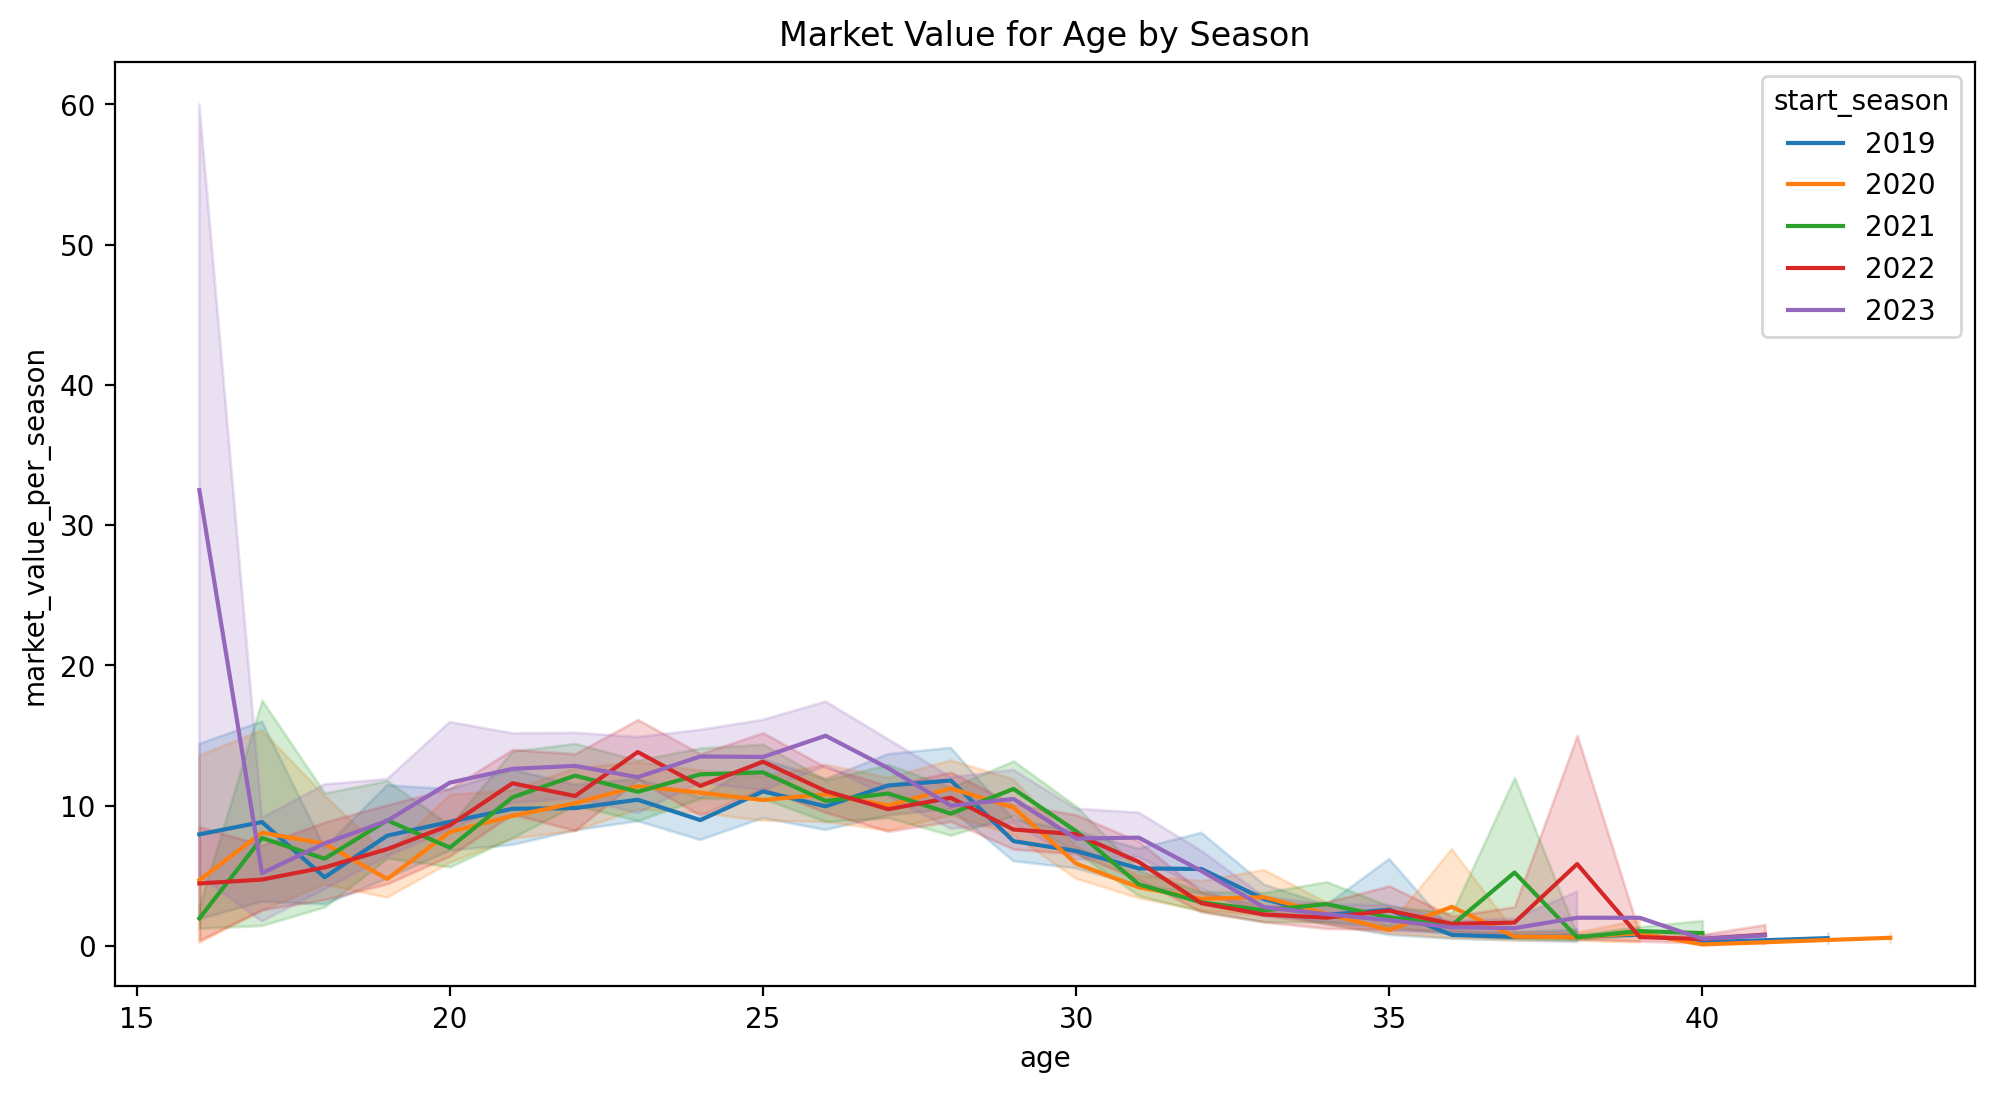

In [119]:
# 시즌, 연령에 따른 선수 몸값 변화

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x=df["age"], y=df["market_value_per_season"]/1000000, hue="start_season", estimator="mean")
plt.title("Market Value for Age by Season")

In [124]:
# 16세에 높은 몸값 자랑하는 선수 확인 → Lamine Yamal

df[df.age==16].sort_values("market_value_per_season", ascending=False).head(10)

player_name start_season  yellow_cards  red_cards  goals  \
8415        Lamine Yamal         2023             2          0      4   
15674  Youssoufa Moukoko         2020             0          0      3   
12565       Rayan Cherki         2019             0          0      0   
4777       Florian Wirtz         2019             0          0      1   
7700   Julien Duranville         2022             0          0      0   
1632      Ayyoub Bouaddi         2023             2          0      0   
13055              Roger         2021             0          0      2   
5653      Harvey Elliott         2019             0          0      0   
10069         Mathys Tel         2021             0          0      0   
11939        Paul Wanner         2021             0          0      0   

       assists  minutes_played    competition_code date_of_birth  age  \
8415         6            1472              laliga    2007-07-13   16   
15674        0             412          bundesliga    2004-11-20   16   
12565        0             139             ligue-1    2003-08-17   16   
4777         0             367          bundesliga    2003-05-03   16   
7700         0              28          bundesliga    2006-05-05   16   
1632         0              91             ligue-1    2007-10-02   16   
13055        0             113  liga-portugal-bwin    2005-11-21   16   
5653         0               7      premier-league    2003-04-04   16   
10069        0              50             ligue-1    2005-04-27   16   
11939        0              35          bundesliga    2005-12-23   16   

                 position                              current_club_name  \
8415         Right Winger                          Futbol Club Barcelona   
15674      Centre-Forward                              Borussia Dortmund   
12565  Attacking Midfield                             Olympique Lyonnais   
4777   Attacking Midfield                    Bayer 04 Leverkusen Fußball   
7700         Right Winger                              Borussia Dortmund   
1632     Central Midfield  Lille Olympique Sporting Club Lille Métropole   
13055         Left Winger                        Sporting Clube de Braga   
5653   Attacking Midfield                        Liverpool Football Club   
10069         Left Winger                              FC Bayern München   
11939  Attacking Midfield                              FC Bayern München   

       market_value_per_season   country   foot  height_in_cm  
8415                60000000.0     Spain   left         180.0  
15674               18000000.0   Germany   left         179.0  
12565               18000000.0    France   both         177.0  
4777                10000000.0   Germany  right         177.0  
7700                 8500000.0   Belgium  right         170.0  
1632                 5000000.0    France  right         185.0  
13055                4000000.0  Portugal   left         166.0  
5653                 3600000.0   England   left         170.0  
10069                2000000.0    France  right         183.0  
11939                2000000.0   Germany   left         185.0

In [57]:
# 시즌별 선수 몸값
fig = px.histogram(data_frame=df, x="market_value_per_season", color="start_season",
                   width=1500, height=700)

fig.update_layout(barmode='overlay',  title_text="Market Value per Season")

fig.update_traces(marker_line_width=2, marker_opacity =0.7)

fig.show()

#### 20M 넘는 선수들로 확인

In [58]:
print("원본 df shape :", df.shape)
print("20M 유로 넘는 선수들 :", df[df.market_value_per_season >= 20000000].shape)

원본 df shape : (16001, 16)
20M 유로 넘는 선수들 : (2288, 16)


In [59]:
fig = px.histogram(data_frame=df[df.market_value_per_season >= 20000000], x="market_value_per_season", color="start_season",
                   width=1500, height=700)

fig.update_layout(barmode='overlay', title_text="Market Value per Season more than 1M Euros")

fig.update_traces(marker_line_width=2, marker_opacity =0.7)

fig.show()

#### 100M 유로 넘는 선수들 확인

In [60]:
df[df.market_value_per_season>=100000000].head(3)

player_name start_season  yellow_cards  red_cards  goals  assists  \
2209  Bukayo Saka         2022             6          0     14       11   
2210  Bukayo Saka         2023             3          0     13       10   
3363  Declan Rice         2023             3          0      6        6   

      minutes_played competition_code date_of_birth  age            position  \
2209            3194   premier-league    2001-09-05   21        Right Winger   
2210            2274   premier-league    2001-09-05   22        Right Winger   
3363            2398   premier-league    1999-01-14   25  Defensive Midfield   

          current_club_name  market_value_per_season  country   foot  \
2209  Arsenal Football Club              120000000.0  England   left   
2210  Arsenal Football Club              120000000.0  England   left   
3363  Arsenal Football Club              110000000.0  England  right   

      height_in_cm  
2209         178.0  
2210         178.0  
3363         188.0

In [61]:
# 시장가치 100M 유로 넘는 선수들 확인

# 시장가치 100M 유로 넘는 선수들 중, player_name으로 groupby한 선수들의 market_value_per_season 최대값 중복해서 조회
mm = df[df.market_value_per_season>=100000000]
more_than_100 = mm.groupby("player_name", as_index=False).market_value_per_season.max().merge(mm)

# 득점, 어시스트 합산해서 공격포인트 (g+a) 컬럼 생성
more_than_100["g+a"] = more_than_100["goals"] + more_than_100["assists"]
more_than_100.sort_values("start_season", ascending=False).head(15)

player_name  market_value_per_season start_season  yellow_cards  \
17      Kylian Mbappé              180000000.0         2023             3   
12      Jamal Musiala              110000000.0         2023             2   
28            Rodrygo              100000000.0         2023             2   
26              Rodri              110000000.0         2023             8   
24         Phil Foden              110000000.0         2023             1   
18   Lautaro Martínez              110000000.0         2023             3   
1         Bukayo Saka              120000000.0         2023             3   
13    Jude Bellingham              180000000.0         2023             5   
34    Vinicius Junior              150000000.0         2023             4   
7       Florian Wirtz              100000000.0         2023             3   
2         Declan Rice              110000000.0         2023             3   
6   Federico Valverde              100000000.0         2023             2   
4      Erling Haaland              180000000.0         2023             1   
22              Pedri              100000000.0         2022             2   
23         Phil Foden              110000000.0         2022             1   

    red_cards  goals  assists  minutes_played competition_code date_of_birth  \
17          0     21        4            1756          ligue-1    1998-12-20   
12          0      8        5            1498       bundesliga    2003-02-26   
28          0      8        5            1944           laliga    2001-01-09   
26          1      6        6            2170   premier-league    1996-06-22   
24          0     11        7            2316   premier-league    2000-05-28   
18          0     23        4            2035          serie-a    1997-08-22   
1           0     13       10            2274   premier-league    2001-09-05   
13          1     16        3            1876           laliga    2003-06-29   
34          0     10        5            1462           laliga    2000-07-12   
7           0      6       10            2006       bundesliga    2003-05-03   
2           0      6        6            2398   premier-league    1999-01-14   
6           0      1        4            2296           laliga    1998-07-22   
4           0     18        5            1925   premier-league    2000-07-21   
22          0      6        1            1982           laliga    2002-11-25   
23          0     11        5            1842   premier-league    2000-05-28   

    age            position                           current_club_name  \
17   25      Centre-Forward           Paris Saint-Germain Football Club   
12   21  Attacking Midfield                           FC Bayern München   
28   23        Right Winger                  Real Madrid Club de Fútbol   
26   27  Defensive Midfield               Manchester City Football Club   
24   23        Right Winger               Manchester City Football Club   
18   26      Centre-Forward  Football Club Internazionale Milano S.p.A.   
1    22        Right Winger                       Arsenal Football Club   
13   20  Attacking Midfield                  Real Madrid Club de Fútbol   
34   23         Left Winger                  Real Madrid Club de Fútbol   
7    20  Attacking Midfield                 Bayer 04 Leverkusen Fußball   
2    25  Defensive Midfield                       Arsenal Football Club   
6    25    Central Midfield                  Real Madrid Club de Fútbol   
4    23      Centre-Forward               Manchester City Football Club   
22   20    Central Midfield                       Futbol Club Barcelona   
23   22        Right Winger               Manchester City Football Club   

      country   foot  height_in_cm  g+a  
17     France  right         178.0   25  
12    Germany  right         184.0   13  
28     Brazil  right         174.0   13  
26      Spain  right         191.0   12  
24    England   left         171.0   18  
18  Argentina  right         174.0   27  
1

In [62]:
more_than_100.shape

(35, 17)

##### Goals, Assists 시각화

In [63]:
# plotly로 scatterplot 확인
import plotly.express as px

fig = px.scatter(data_frame=more_than_100.sort_values("start_season"), x="goals", y="assists", color="player_name", 
                 size="goals", facet_row="start_season", text="player_name",
                 width=1200, height=2000)

fig.update_layout(title_text="Scatterplot by Goals and Assists per Season more than 5 Games")
fig.update_traces(textposition="top right")
fig.show()

##### 공격포인트 합산 시각화

In [64]:
# 득점 + 어시스트 하나로 합친 공격포인트 시각화

# plotly로 scatterplot 확인
import plotly.express as px

fig = px.scatter(data_frame=more_than_100.sort_values("start_season"), x="market_value_per_season", y="g+a", color="player_name", 
                 size="goals", facet_row="start_season",
                 text="player_name",
                 width=1200, height=2000)

fig.update_layout(title_text="Scatterplot by Goals and Assists per Season more than 5 Games")
fig.update_traces(textposition="top center")
fig.show()

#### 포지션별 평균 market_value_per_season

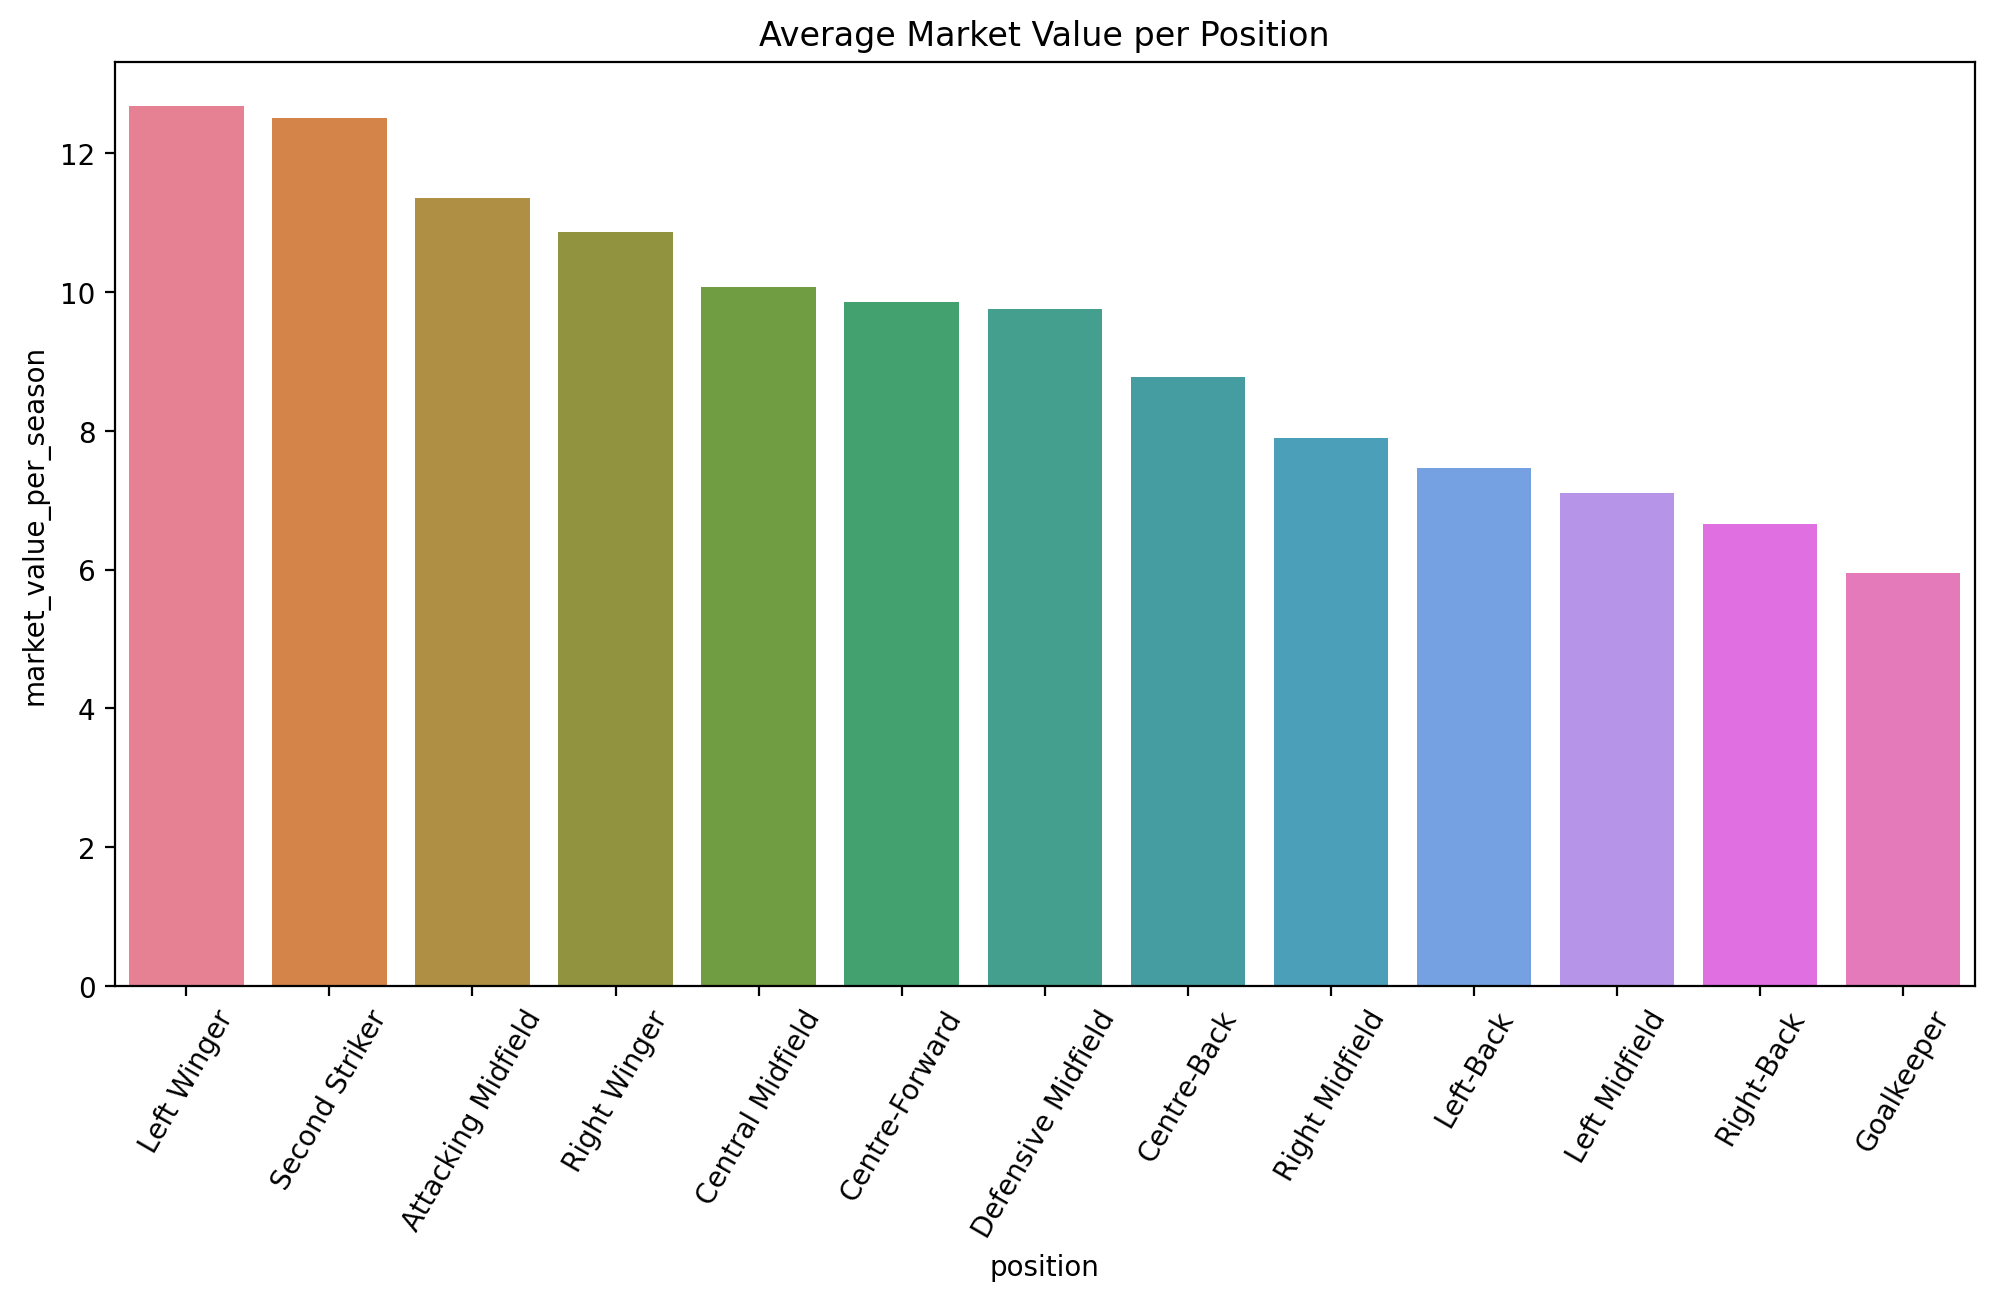

In [137]:
plt.figure(figsize=(12, 6))

per_position = df.groupby("position").mean("market_value_per_season").sort_values("market_value_per_season", ascending=False)

g = sns.barplot(data=per_position, x="position", y=per_position["market_value_per_season"]/1000000, hue="position")
g.set_xticklabels(g.get_xticklabels(), rotation=60)
plt.title("Average Market Value per Position")
plt.show()


### `Age` 분석

#### 100M 유로 넘는 선수들끼리 비교

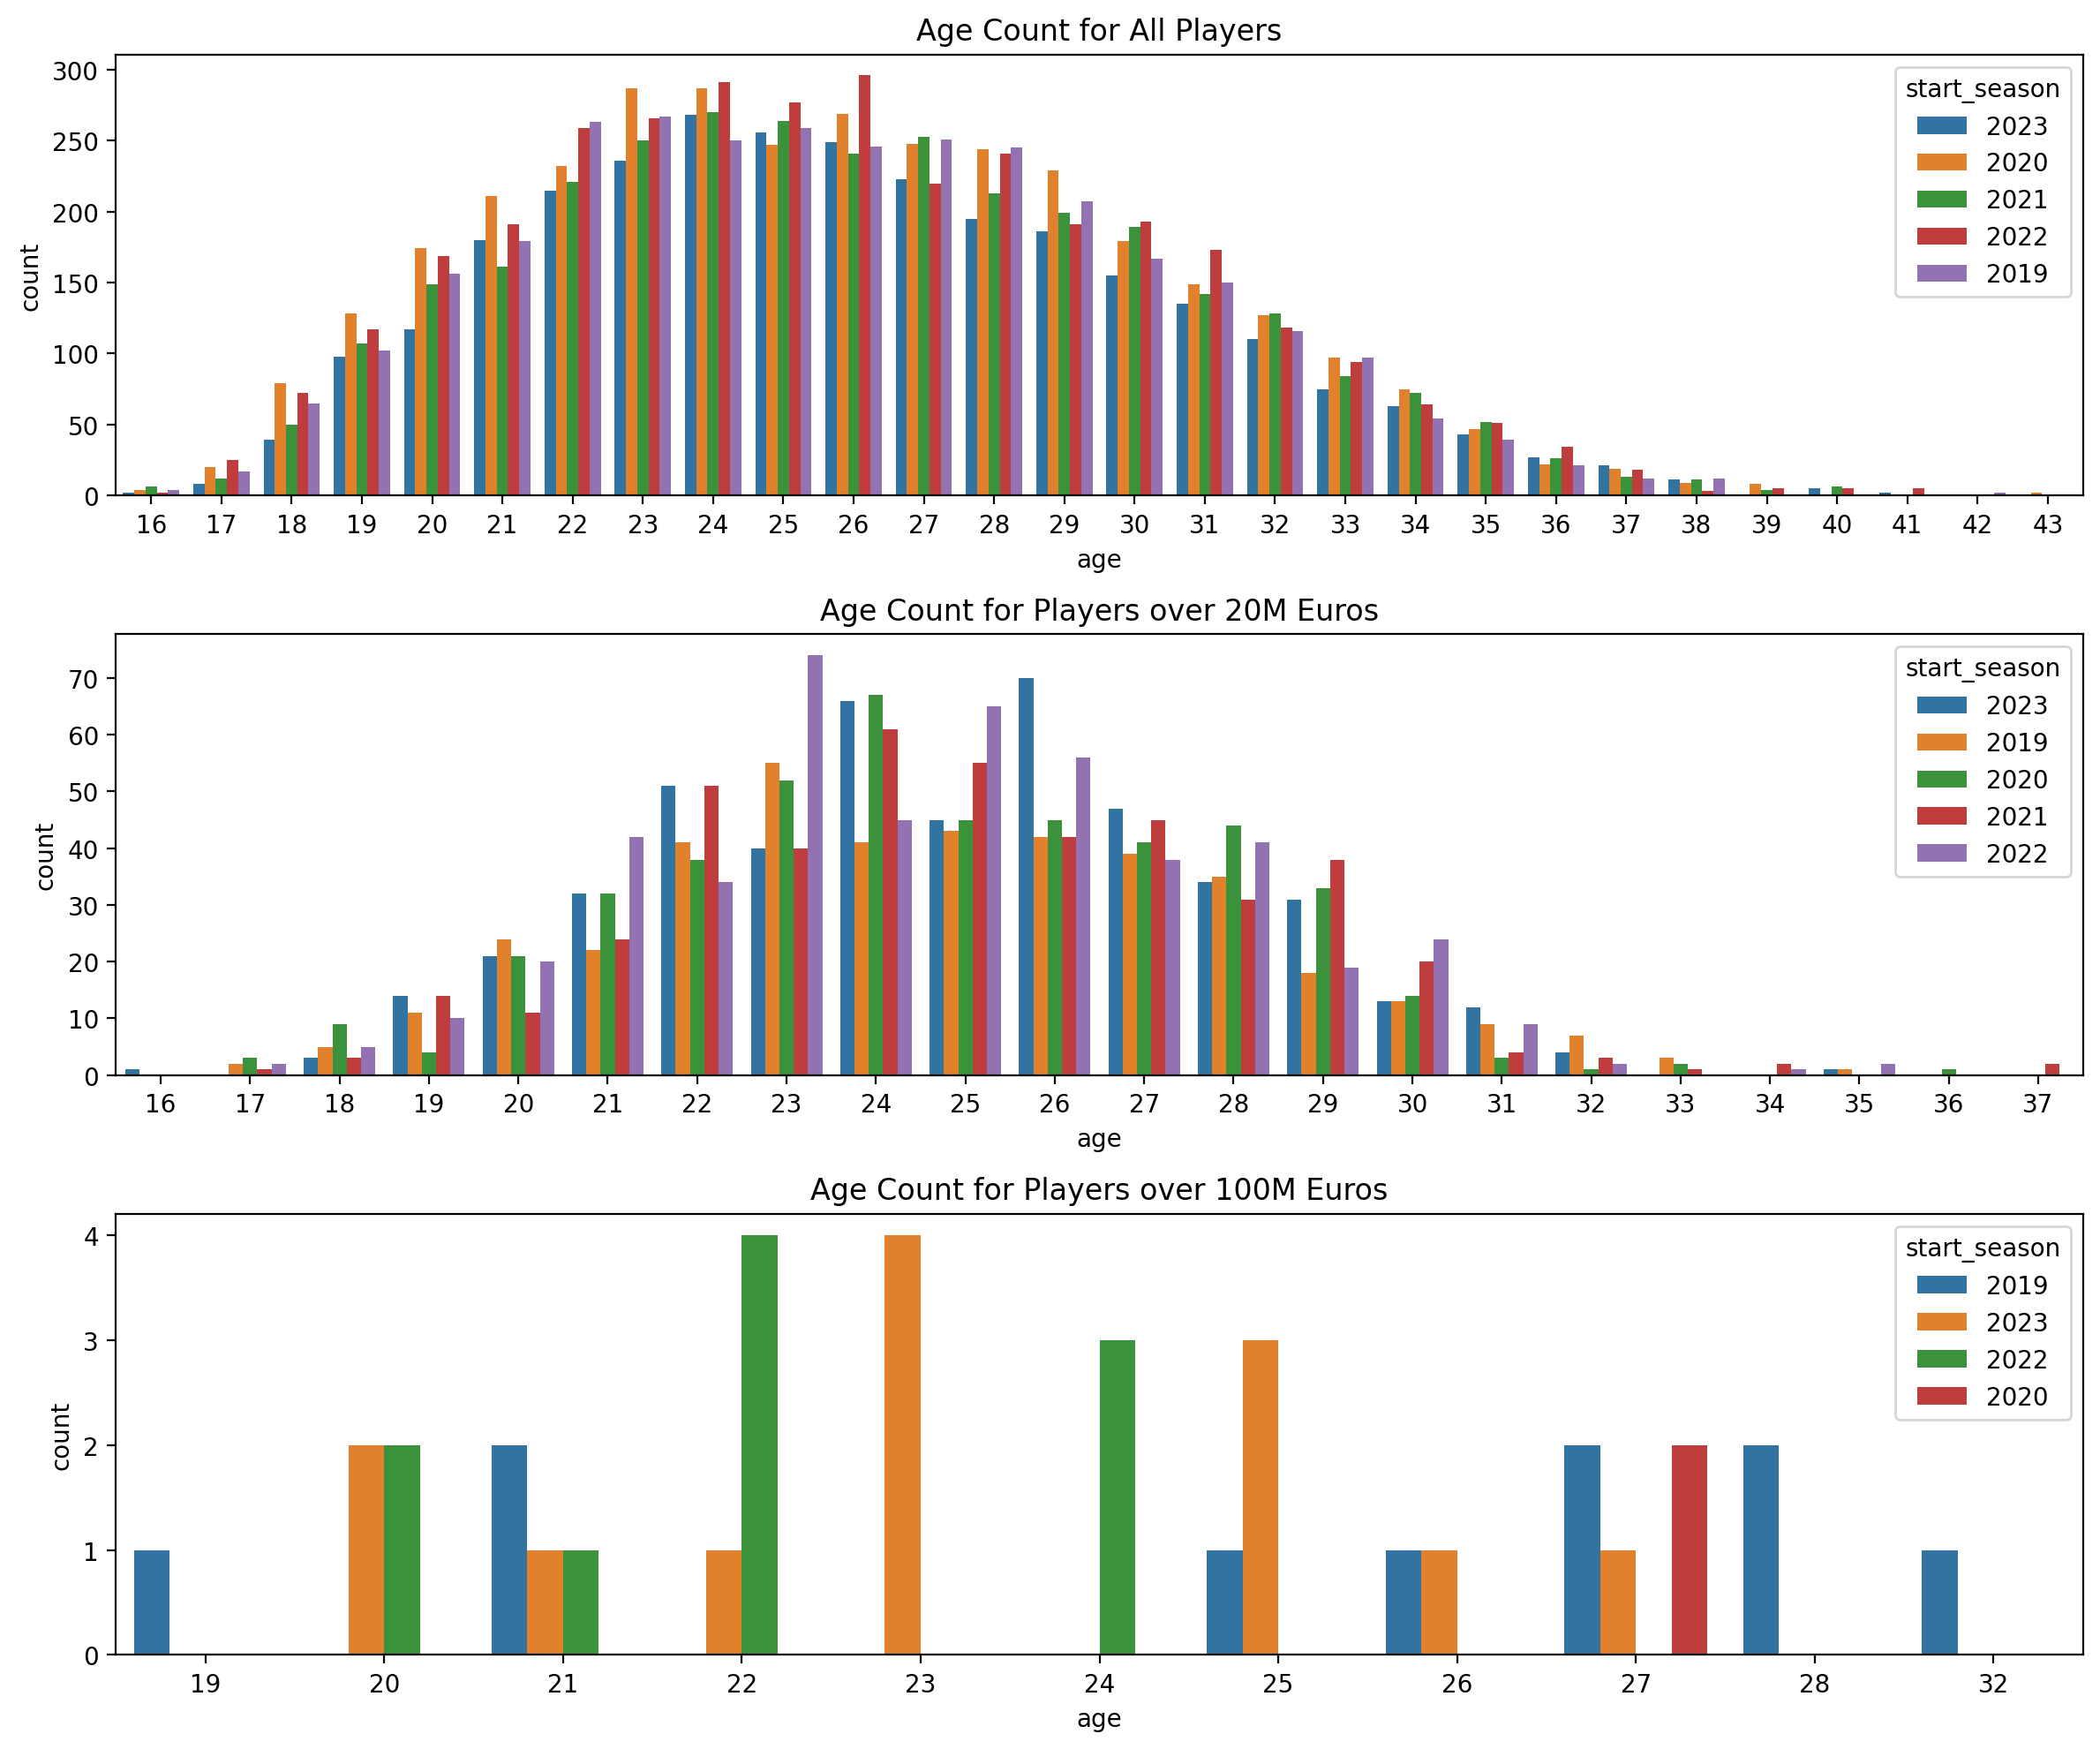

In [158]:
nrows, ncols = 3, 1
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 10))

hue_order = [2019, 2020, 2021, 2022, 2023]
# flatten()을 통해axes를 1차원 array로 펴줘야 한다
# axes = axes.T.flatten()

g1 = sns.countplot(data=df, x="age", hue="start_season", ax=axes[0])
g2 = sns.countplot(data=df[df.market_value_per_season >= 20000000], x="age", hue="start_season", ax=axes[1])
g3 = sns.countplot(data=more_than_100, x="age", hue="start_season", ax=axes[2])

g1.set_title("Age Count for All Players")
g2.set_title("Age Count for Players over 20M Euros")
g3.set_title("Age Count for Players over 100M Euros")

plt.tight_layout()
plt.show()


##### 100M 유로 넘는 선수들 공격포인트와 `age` 비교

In [68]:
# 득점 + 어시스트 하나로 합친 공격포인트 시각화

# plotly로 scatterplot 확인
import plotly.express as px

fig = px.scatter(data_frame=more_than_100.sort_values("start_season"), x="age", y="g+a", color="player_name", 
                 size="goals", facet_row="start_season",
                 text="player_name",
                 width=1200, height=2000)

fig.update_layout(title_text="Scatterplot by Goals and Assists per Season more than 5 Games")
fig.update_traces(textposition="top center")
fig.show()

##### 100M 유로 넘는 선수들 `market_value_per_season`과 `age` 비교

In [69]:
# 나이에 따른 market_value_per_season 시각화

# plotly로 scatterplot 확인
import plotly.express as px

fig = px.scatter(data_frame=more_than_100.sort_values("start_season"), x="age", y="market_value_per_season",
                 color="player_name", 
                 size="goals", facet_row="start_season",
                 text="player_name",
                 width=1200, height=2000)

fig.update_layout(title_text="Scatterplot by Goals and Assists per Season more than 5 Games")
fig.update_traces(textposition="top center")
fig.show()

## EDA 거친 데이터셋 `csv`로 저장

In [159]:
df.to_csv("data/df_eda.csv", index=False)